In [1]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [2]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [3]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [4]:
qfl_factors = qfl_value # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [5]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [6]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [7]:
qfl_df = df

In [8]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)"
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,2.896269,3.400158,3.368390,3.558475,0.688786,0.735155,0.725872,0.781422,0.032962,0.027515,0.026216,NaN,0.024528,0.023562,4.069840,4.364474,4.310444,4.633740,3.701116,3.840130,3.782173,4.128966,0.138303,0.160761,0.159386,0.167612,3.794066,4.620283,4.586364,4.789324,3.244983,3.979834,3.935598,4.200287,3.643585,3.780438,3.723382,4.064784,3.431073,4.064911,4.032780,4.225039,0.085614,0.082927,0.081649,0.136153,0.158262,0.156909,0.165007,4.359060,3.713066,3.748085,3.547871,4.010325,3.397712,3.433439,3.229286
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,2.918797,3.291511,3.165014,3.466788,1.046387,1.043441,1.015244,1.082512,0.075829,0.085226,0.101680,0.044602,0.074835,0.095997,4.067733,4.465352,4.265662,4.742045,3.025296,3.102482,2.972066,3.283189,0.090407,0.100362,0.096450,0.105781,4.363731,4.939514,4.711505,5.255448,3.570719,4.055735,3.877933,4.302102,3.130651,3.210524,3.075567,3.397524,3.284993,3.665087,3.489891,3.907844,0.125770,0.128609,0.145636,0.093555,0.103857,0.099809,0.109465,1.598971,1.417912,1.474582,1.346224,1.524520,1.352069,1.407874,1.281481
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,1.083850,1.429439,1.124772,1.457717,0.000000,0.000000,0.000000,0.000000,0.051629,0.056796,0.080059,0.042298,NaN,NaN,3.448711,4.246544,3.517875,4.314175,1.538298,2.531966,1.569221,2.621322,0.217023,0.275690,0.236626,0.279316,2.710223,4.100751,3.281530,4.176786,1.250523,1.765561,1.263629,1.812147,1.512439,2.489403,1.542842,2.577258,0.831924,2.357581,1.475119,2.439487,0.100751,0.076389,0.098954,0.213375,0.271056,0.232648,0.274620,1.776629,1.347101,1.711991,1.320970,1.776629,1.347101,1.711991,1.320970
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,3.194175,3.795488,3.393655,3.832784,0.000000,0.000000,0.000000,0.000000,0.148785,0.158608,0.201627,0.123794,0.133011,0.164278,4.638536,5.902747,4.884094,5.997293,2.793181,3.327332,2.903743,3.366647,0.099807,0.129841,0.106225,0.132032,4.717606,6.591865,5.830592,6.662521,3.851397,4.772218,4.077750,4.836675,2.960408,3.526539,3.077589,3.568208,2.761771,3.860249,3.712755,3.873939,0.171262,0.168104,0.213699,0.105783,0.137614,0.112584,0.139937,1.195434,1.006043,1.125166,0.996253,1.195434,1.006043,1.125166,0.996253
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,2.949484,3.437809,2.921742,3.485707,0.000000,0.000000,0.000000,0.000000,0.175847,0.184196,0.216998,0.157356,NaN,NaN,4.697139,5.952622,4.925555,6.047948,2.809661,3.908502,3.154020,3.97

In [9]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)"
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,2.846347,8.207607,2.617923,8.726411,7.679701,7.693219,7.691573,7.693373,1.021488,1.264704,1.271106,1.010481,NaN,NaN,7.850093,NaN,NaN,NaN,7.841479,NaN,NaN,NaN,0.188017,0.187723,0.190871,0.187430,5.235334,5.196824,5.085518,5.207155,5.210511,NaN,NaN,NaN,3.509178,NaN,NaN,NaN,5.231479,4.837213,4.825172,4.838330,0.883542,1.078663,1.086952,0.084140,0.084009,0.085418,0.083878,11.688051,4.053344,12.707880,3.812364,3.287869,1.138772,3.570781,1.071054
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,9.683292,8.654063,8.730366,8.616224,4.761905,4.761905,4.761905,4.761905,0.824255,0.838985,0.875761,0.706833,NaN,NaN,43.870243,NaN,NaN,NaN,42.273600,NaN,NaN,NaN,0.499021,0.498630,0.495368,0.500248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,4.444969,6.111264,1.724601,6.518409,5.523468,5.523443,5.523443,5.523443,1.200671,1.241428,1.256379,1.200671,NaN,NaN,6.662738,NaN,NaN,NaN,6.662738,NaN,NaN,NaN,0.192687,0.187456,0.198015,0.186476,4.556962,4.759684,4.640342,4.770760,4.494833,NaN,NaN,NaN,2.821223,NaN,NaN,NaN,4.556962,4.521364,4.368044,4.535594,1.043245,1.123573,1.100999,0.081590,0.079375,0.083846,0.078960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,-78.677570,-36.245490,-104.011640,-2.640143,0.000000,0.443388,0.000000,0.663265,1.906533,1.564685,1.515781,1.800833,NaN,NaN,6.152213,-9.000290,-68.606420,20.558489,-30.378883,-47.154438,-118.128460,-11.958303,5.670426,5.783432,5.119124,6.112864,-2.605879,8.917801,-15.178090,20.866993,-21.695053,-9.280788,-32.517290,2.242230,-24.925558,-38.689728,-96.923190,-9.811663,-11.232208,-13.643505,-31.715118,-4.681761,2.495523,2.762764,2.566804,4.652526,4.745246,4.200188,5.015542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,3.508452,5.562809,4.784050,5.948997,2.825230,2.969273,2.797489,3.054460,1.187502,1.219622,1.253639,1.181334,NaN,NaN,13.256055,8.532168,11.548666,7.036282,10.716638,2.794132,2.038891,3.168657,0.692787,0.742048,0.684212,0.770729,14.069875,15.853727,14.395637,16.576794,9.971419,11.024484,9.597092,11.732329,15.840793,4.130144,3.013785,4.683748,10.184306,10.940131,9.574132,11.617532,1.761042,1.842045,1.892326,1.024042,1.096858,1.011368,1.139253,2.490077,1.570487,1.826134,1.468536,1.997141,1.247007,1.467485,1.159205


In [10]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)"
count,1600.0,1600.000000,1597.000000,1.598000e+03,1596.000000,1593.000000,1593.000000,1593.000000,1598.000000,1587.000000,1587.000000,1584.000000,1598.000000,1590.000000,1584.000000,1551.000000,438.000000,434.000000,1596.000000,1451.000000,1451.000000,1451.000000,1595.000000,1381.000000,1381.000000,1381.000000,1596.000000,1587.000000,1587.000000,1587.000000,1573.000000,1463.000000,1463.000000,1463.000000,1573.000000,1562.000000,1562.000000,1562.000000,1572.000000,1378.000000,1378.000000,1378.000000,1573.000000,1386.000000,1386.000000,1384.000000,1575.000000,1169.000000,1166.000000,1573.000000,1565.000000,1565.000000,1565.000000,1190.000000,1333.000000,1273.000000,1346.000000,1190.000000,1327.000000,1267.000000,1339.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,1.863010,5.153502,3.427689,5.516963,2.101785,2.470494,2.267221,2.518676,0.556873,0.594628,0.618093,0.316196,0.527596,0.585215,10.368214,9.751453,8.334802,10.043679,5.362166,4.270823,2.751084,4.585765,0.772554,0.803527,0.760947,0.814577,8.009394,9.360995,8.121967,9.658149,4.869115,6.498788,5.271286,6.767842,2.862750,3.689160,2.055642,3.953539,5.130363,5.846519,4.733829,6.121927,0.727149,0.637093,0.653675,0.586003,0.637909,0.605817,0.646092,9.257090,5.947207,6.680555,5.256891,4.444331,2.678925,3.380131,2.403820
std,0.0,0.177252,7.256757,9.150908e+04,9.867216,4.278136,7.447003,3.956886,2.044933,2.446459,2.412002,2.460273,0.578589,0.606006,0.616213,0.634224,1.005297,1.295484,24.681498,9.049909,9.986254,9.146491,16.952155,6.190560,12.113581,5.901008,1.066324,1.129643,1.089423,1.145974,24.074506,23.508067,23.058981,23.593988,21.305822,20.266668,20.387313,20.230566,68.024876,13.409565,15.290184,15.757478,22.594963,21.519511,21.317135,21.550745,2.128560,0.533430,0.537050,1.515291,2.139675,2.131308,2.138238,60.123568,31.942368,38.756861,27.351353,12.851733,6.213650,10.662465,3.806666
min,890100.0,0.002419,-31.602722,2.063382e+03,-147.967710,-36.245490,-104.011640,-23.500640,0.000000,0.000000,0.000000,0.000000,-0.837521,-0.663015,-0.692458,-4.215002,-0.492581,-0.495636,-246.590400,-18.932034,-70.141590,-17.077177,-248.052120,-47.154438,-289.421500,-36.229370,-0.054652,0.000709,0.000677,0.000712,-59.123695,-17.321976,-43.952640,-19.570208,-73.427185,-17.455720,-75.214090,-17.767849,-2588.280000,-38.689728,-513.483640,-39.708496,-64.837296,-18.848042,-78.887670,-14.858858,-0.104717,0.017346,0.021067,-0.054254,0.000687,0.000656,0.000690,0.043621,0.030387,0.036389,0.029929,0.043121,0.030026,0.035993,0.029571
25%,890100.0,0.012927,-1.169592,8.494103e+03,1.032512,2.976330,1.966715,3.217629,0.404704,0.845294,0.704736,0.894856,0.158287,0.176113,0.196323,-0.007576,0.030815,0.040507,3.828236,4.367179,3.638483,4.533437,1.730747,2.247740,1.643960,2.360645,0.179564,0.193944,0.179032,0.199230,3.952207,4.969721,4.287793,5.161440,2.199399,3.492531,2.758625,3.728606,1.422810,2.006267,1.408153,2.090685,2.080567,3.105811

In [11]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID         0
DATE                 0
SECURITY_ID          0
Weight               0
proper_name          0
                  ... 
QFL_PEG(0,FY2)     254
QFL_PEGY(0,CT)     410
QFL_PEGY(0,NTM)    273
QFL_PEGY(0,FY1)    333
QFL_PEGY(0,FY2)    261
Length: 67, dtype: int64

In [12]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

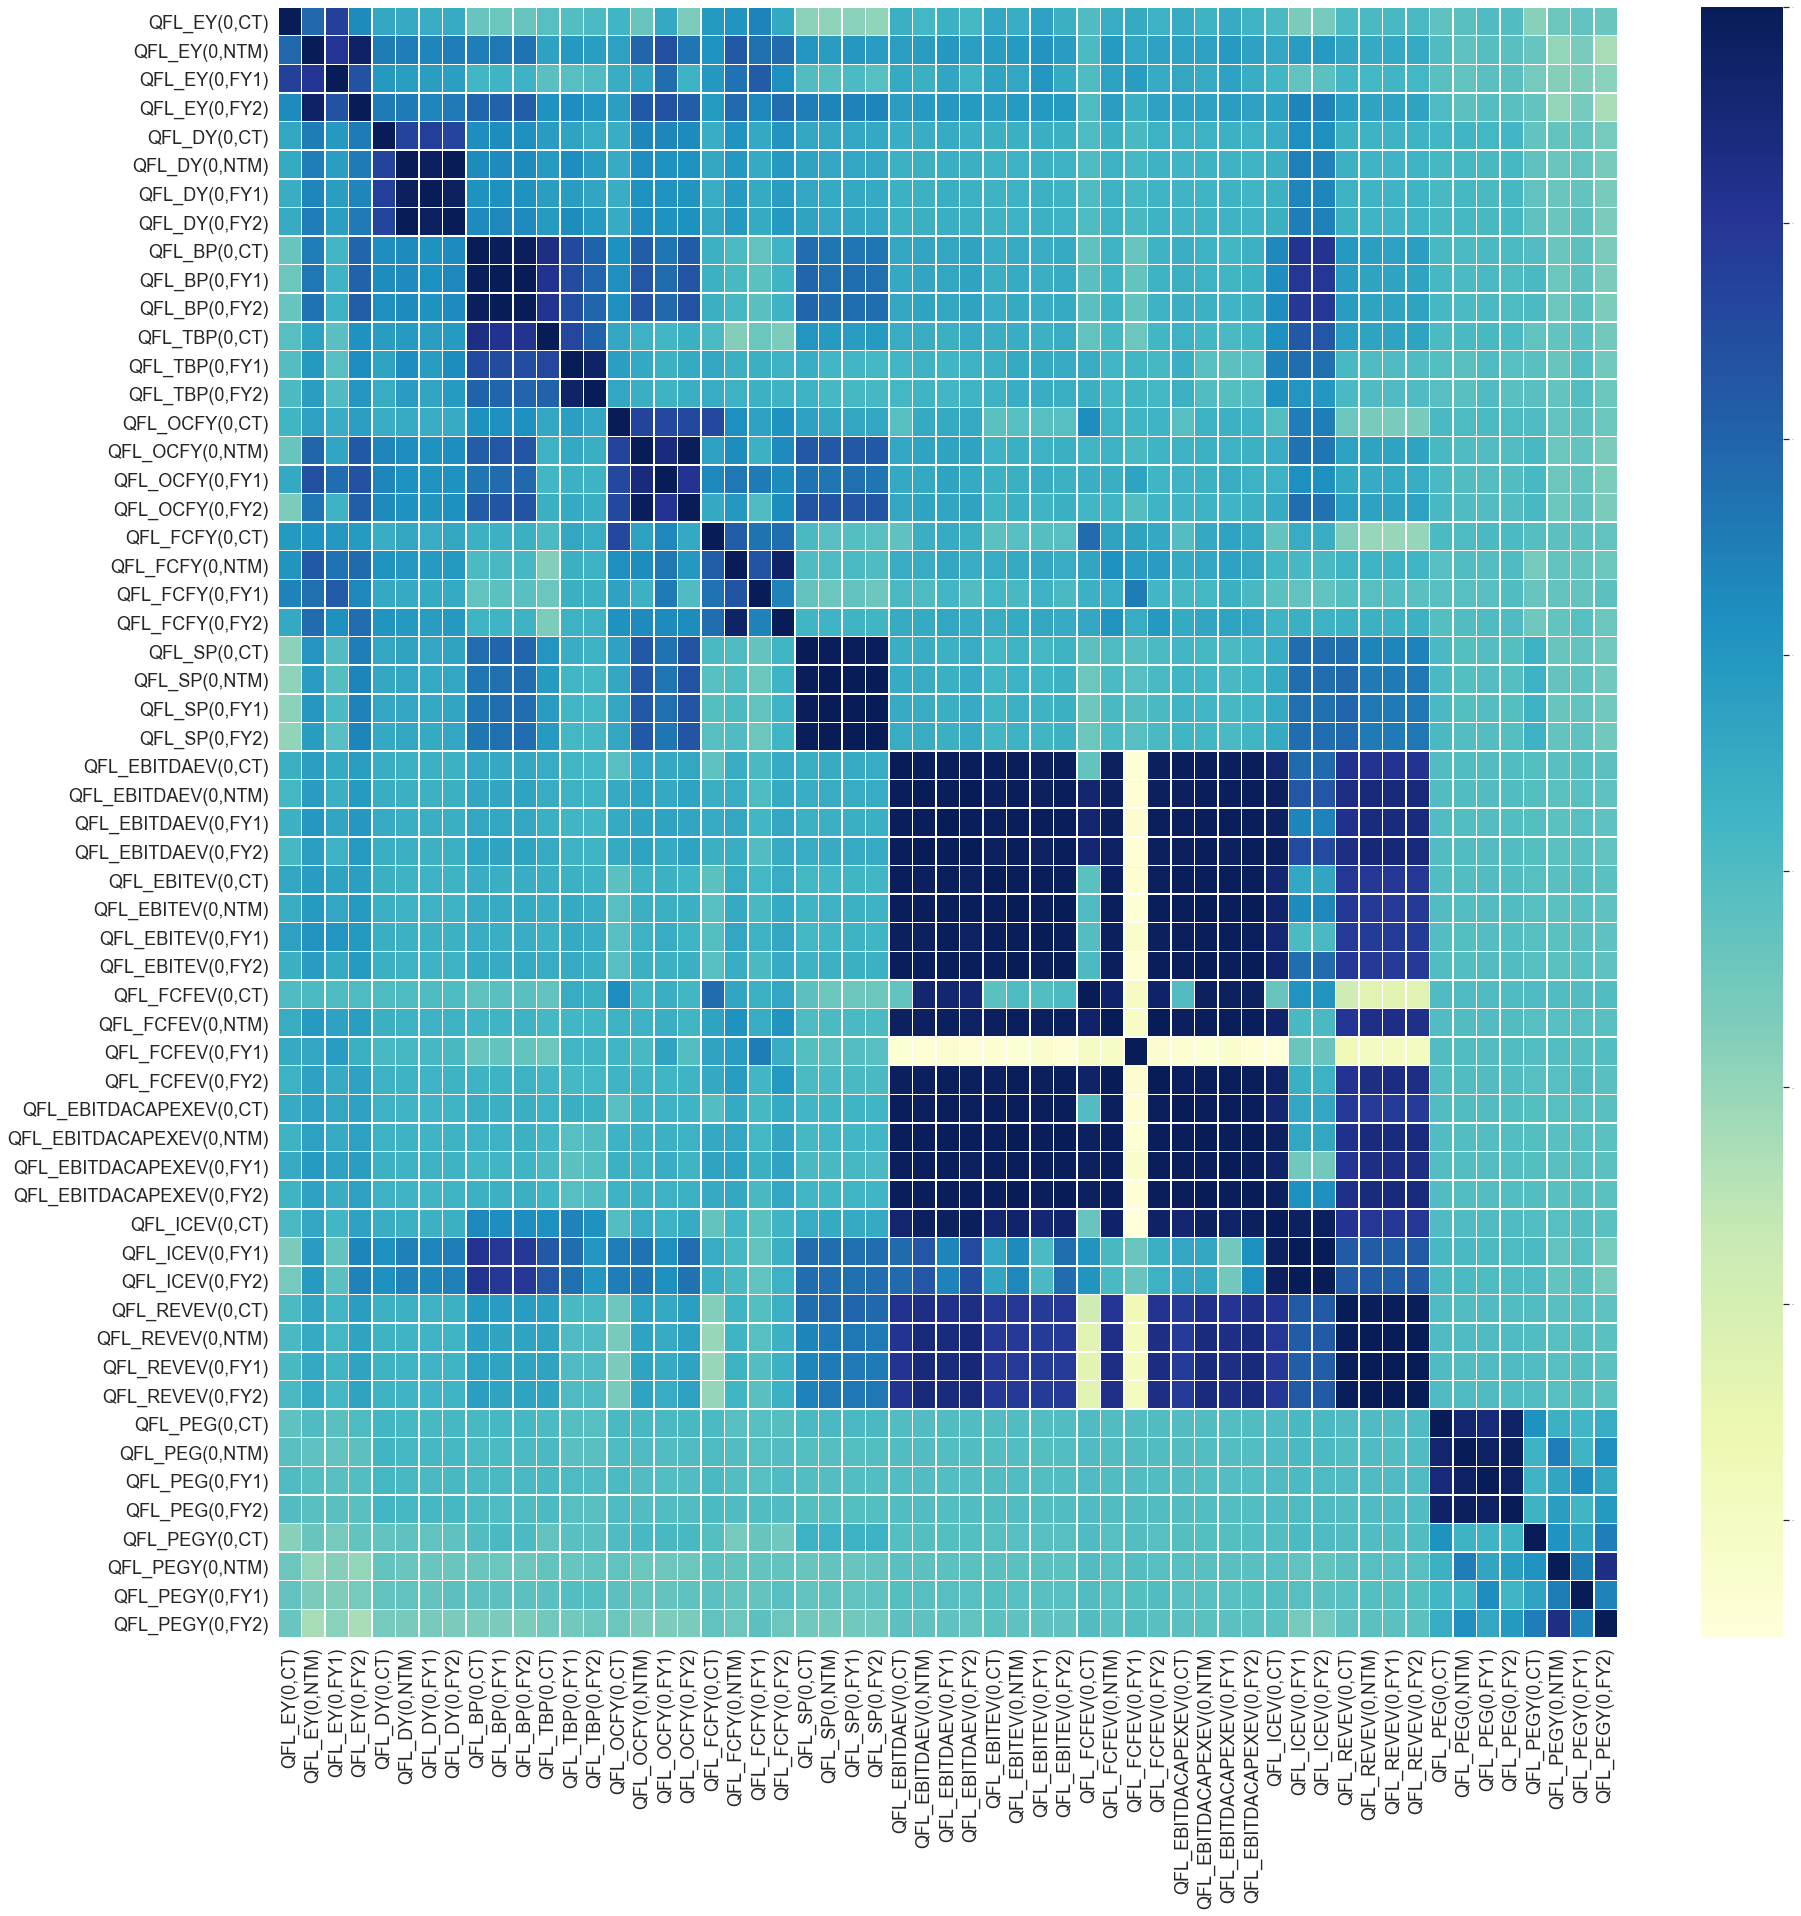

In [94]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

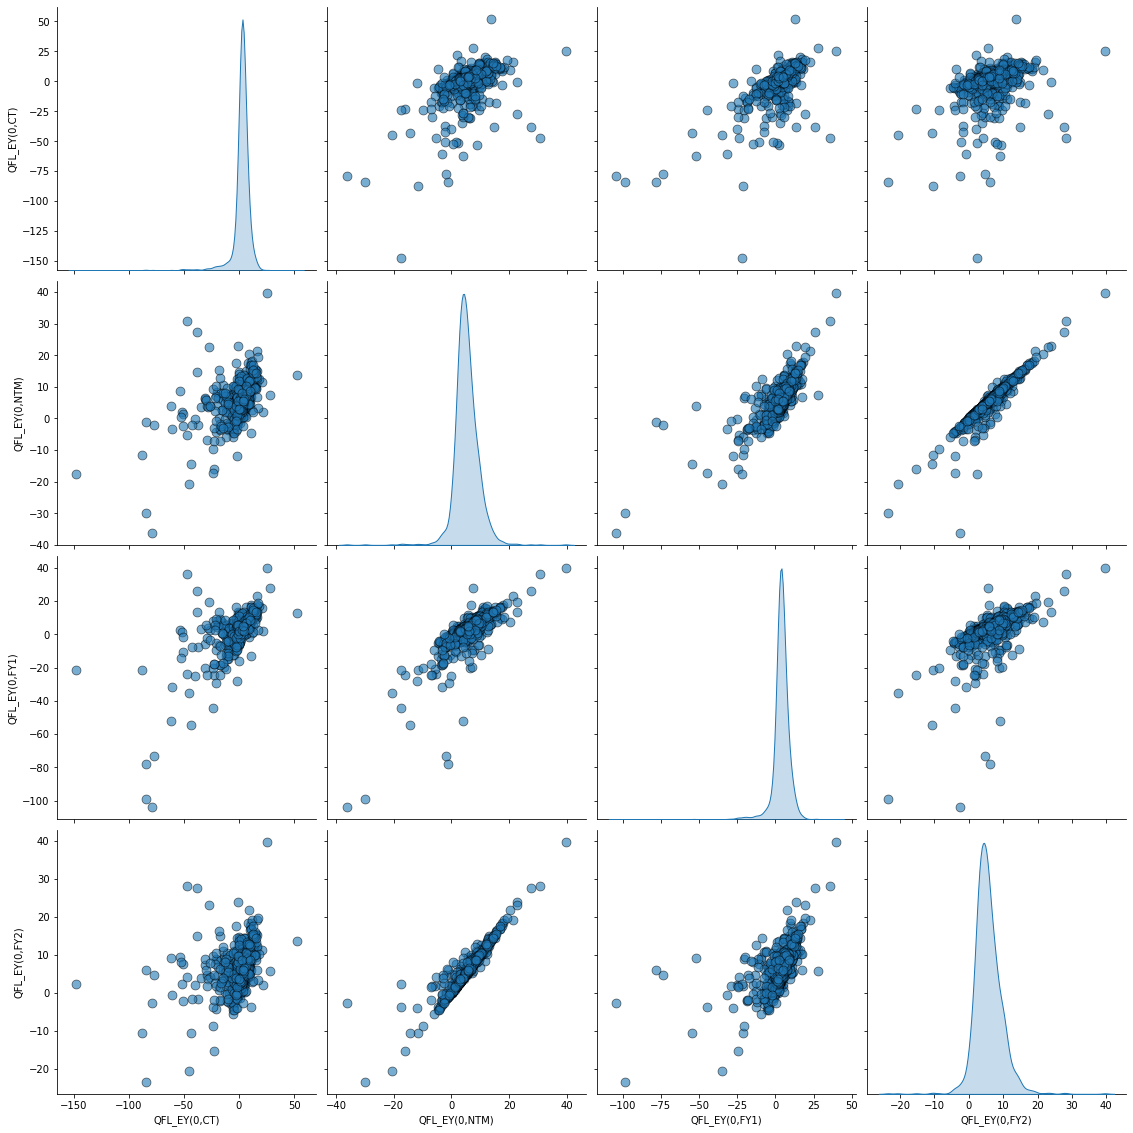

In [14]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [15]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)"
0,2.896269,3.400158,3.368390,3.558475
1,2.918797,3.291511,3.165014,3.466788
2,1.083850,1.429439,1.124772,1.457717
3,3.194175,3.795488,3.393655,3.832784
4,2.949484,3.437809,2.921742,3.485707
...,...,...,...,...
1595,2.846347,8.207607,2.617923,8.726411
1596,9.683292,8.654063,8.730366,8.616224
1597,4.444969,6.111264,1.724601,6.518409
1598,-78.677570,-36.245490,-104.011640,-2.640143


In [16]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
"QFL_EY(0,CT)",1596,"[-147.97, 52.19]",1.86,97.36,-5.72,56.11
"QFL_EY(0,NTM)",1593,"[-36.25, 39.62]",5.15,18.3,-0.53,14.57
"QFL_EY(0,FY1)",1593,"[-104.01, 39.87]",3.43,55.46,-6.2,71.6
"QFL_EY(0,FY2)",1593,"[-23.5, 39.59]",5.52,15.66,0.54,8.78
"QFL_DY(0,CT)",1598,"[0.0, 16.97]",2.1,4.18,1.46,4.04
"QFL_DY(0,NTM)",1587,"[0.0, 61.13]",2.47,5.99,9.12,206.98
"QFL_DY(0,FY1)",1587,"[0.0, 58.21]",2.27,5.82,8.47,181.54
"QFL_DY(0,FY2)",1584,"[0.0, 61.4]",2.52,6.05,9.06,205.8
"QFL_BP(0,CT)",1598,"[-0.84, 4.47]",0.56,0.33,2.2,7.35
"QFL_BP(0,FY1)",1590,"[-0.66, 6.74]",0.59,0.37,2.43,11.29


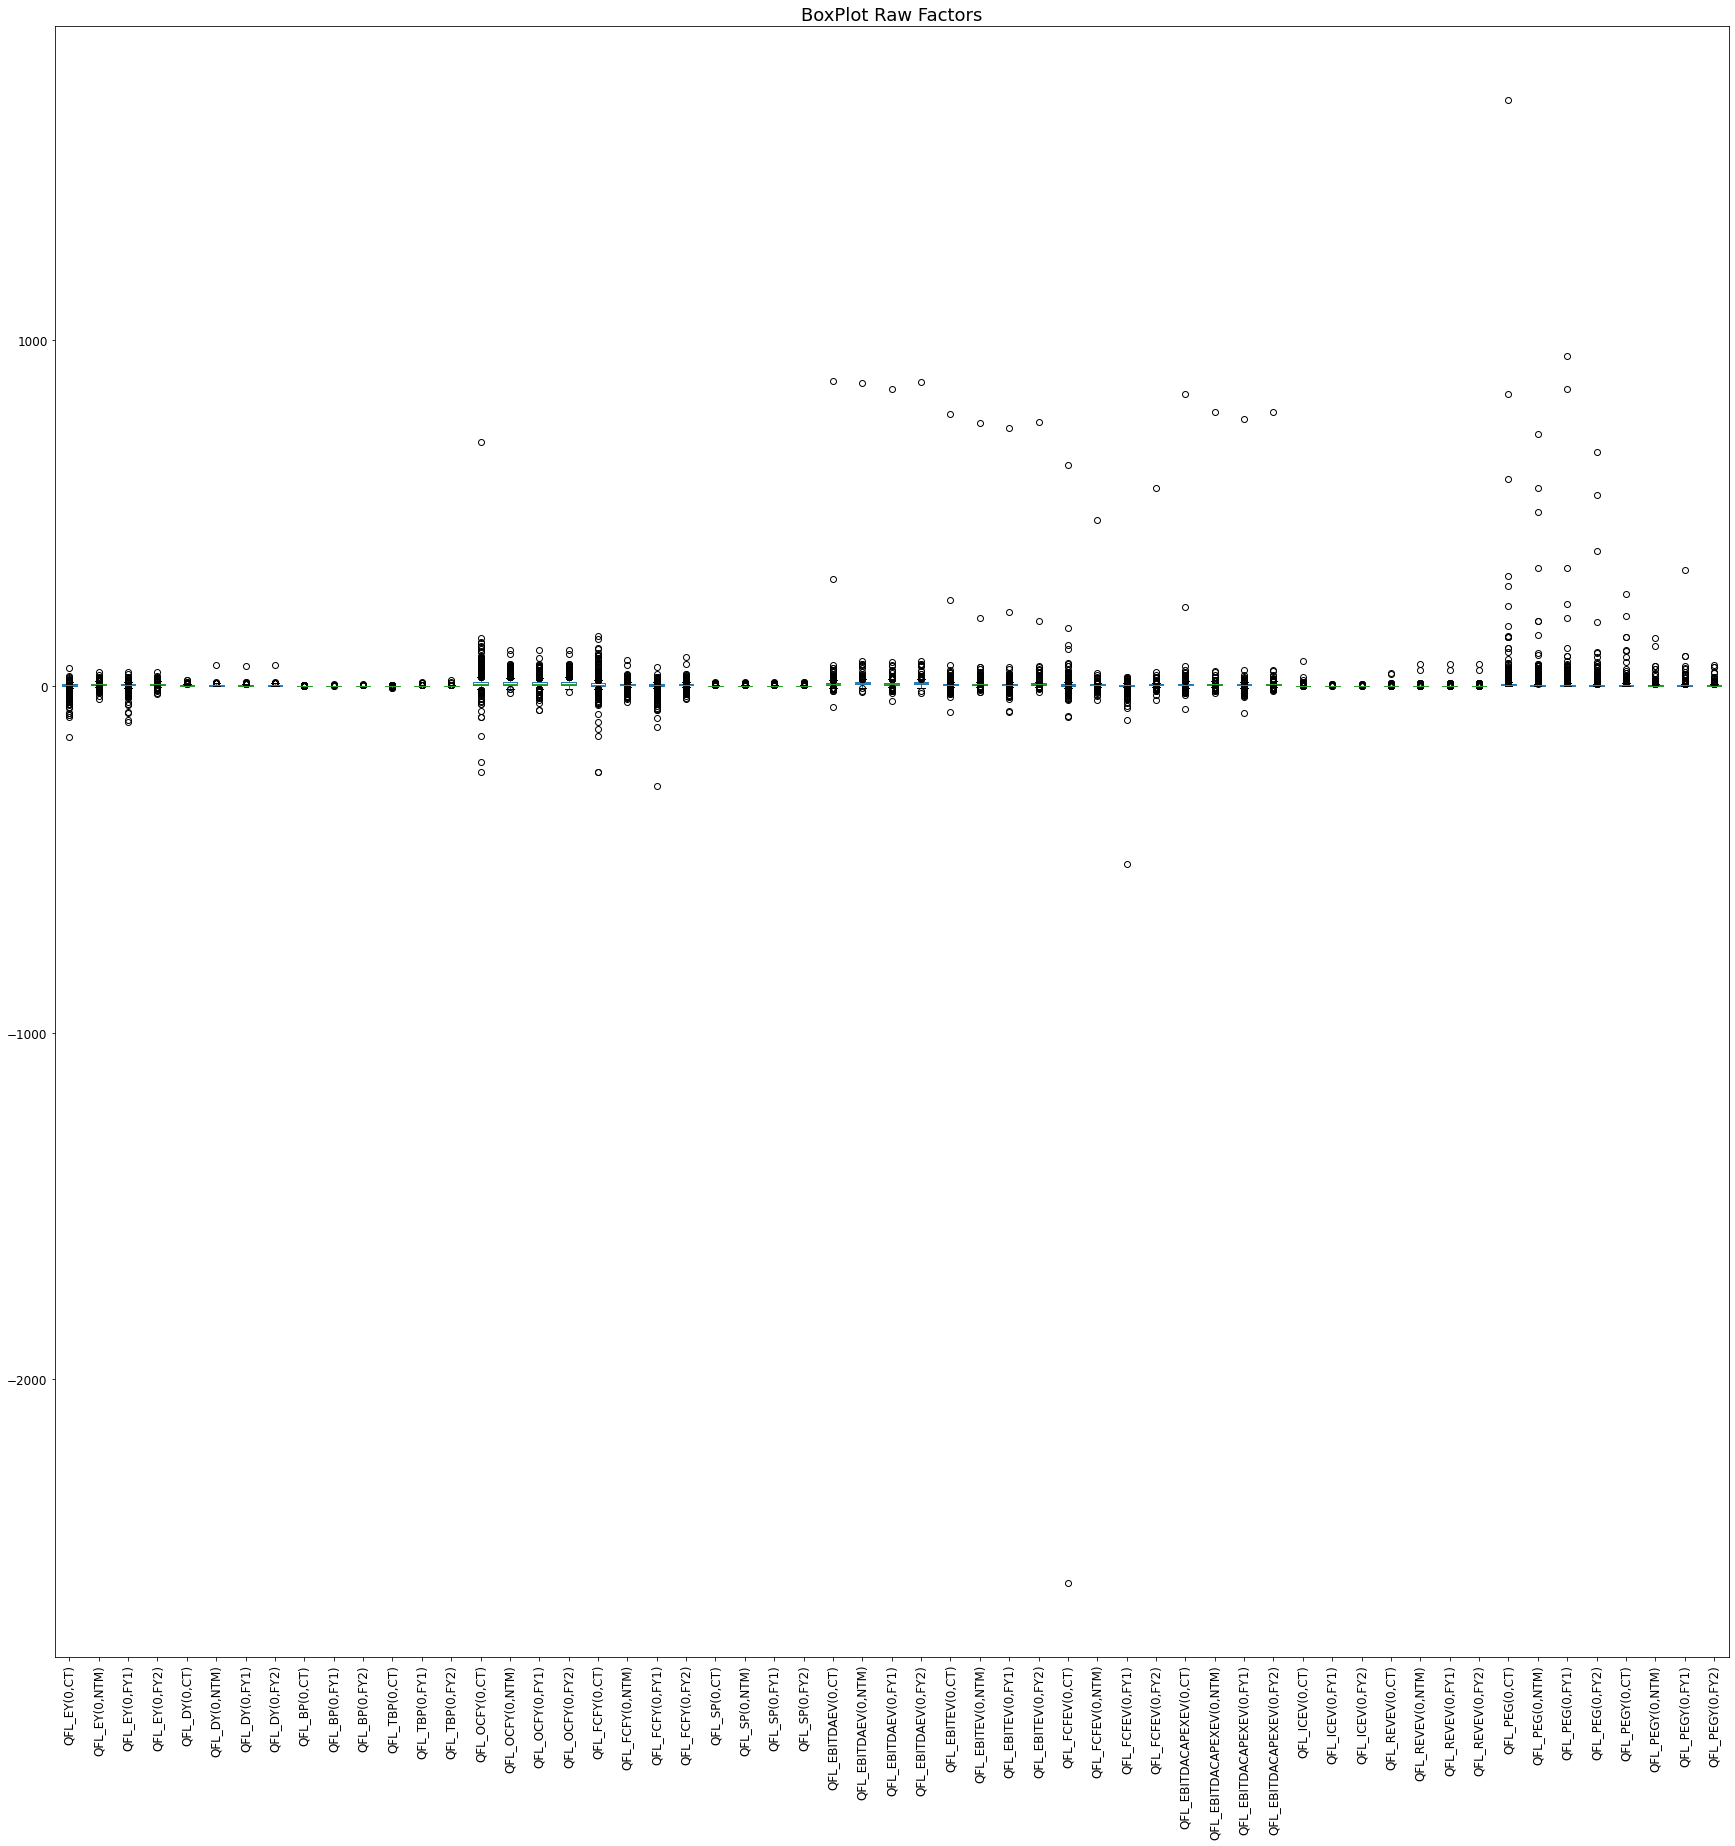

In [17]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [18]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)"
count,1.596000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.598000e+03,1.587000e+03,1.587000e+03,1.584000e+03,1.598000e+03,1.590000e+03,1.584000e+03,1.551000e+03,4.380000e+02,4.340000e+02,1.596000e+03,1.451000e+03,1.451000e+03,1.451000e+03,1.595000e+03,1.381000e+03,1.381000e+03,1.381000e+03,1.596000e+03,1.587000e+03,1.587000e+03,1.587000e+03,1.573000e+03,1.463000e+03,1.463000e+03,1.463000e+03,1.573000e+03,1.562000e+03,1.562000e+03,1.562000e+03,1.572000e+03,1.378000e+03,1.378000e+03,1.378000e+03,1.573000e+03,1.386000e+03,1.386000e+03,1.384000e+03,1.575000e+03,1.169000e+03,1.166000e+03,1.573000e+03,1.565000e+03,1.565000e+03,1.565000e+03,1.190000e+03,1.333000e+03,1.273000e+03,1.346000e+03,1.190000e+03,1.327000e+03,1.267000e+03,1.339000e+03
mean,3.389276e-16,2.118162e-15,5.606522e-16,2.249352e-15,-7.866048e-16,-2.317687e-16,-1.888673e-15,3.088158e-16,-1.358113e-15,-2.302840e-15,-7.782776e-16,3.378628e-17,1.323143e-16,1.160106e-16,-6.057185e-17,-1.065653e-16,-2.244931e-16,1.563226e-15,8.267159e-16,-3.690426e-16,-1.206644e-16,-8.919770e-16,4.198553e-16,-3.699913e-16,5.497423e-16,6.660376e-16,1.539349e-16,9.887284e-16,9.277534e-16,-4.169218e-16,-3.802143e-16,3.599873e-16,1.507721e-16,3.269898e-16,5.886583e-17,2.087912e-16,-1.308822e-16,-3.843936e-16,-1.832256e-16,7.395479e-17,1.396790e-16,-5.291207e-16,-5.145796e-16,1.365318e-15,1.129647e-15,5.816849e-16,9.555721e-17,-2.553868e-18,-1.521325e-16,-8.133083e-17,1.320732e-16,-1.453407e-16,1.882678e-17,7.007000e-16,1.175063e-16,-4.981545e-17,3.132089e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.518470e+01,-9.676876e+00,-1.442719e+01,-7.333445e+00,-1.027801e+00,-1.009824e+00,-9.399746e-01,-1.023738e+00,-2.409992e+00,-2.075298e+00,-2.126783e+00,-7.144477e+00,-1.014802e+00,-8.343215e-01,-1.041098e+01,-3.169478e+00,-7.858441e+00,-2.965165e+00,-1.494880e+01,-8.307045e+00,-2.411942e+01,-6.916638e+00,-7.757545e-01,-7.106831e-01,-6.978649e-01,-7.101952e-01,-2.788555e+00,-1.135056e+00,-2.258322e+00,-1.238805e+00,-3.674878e+00,-1.181966e+00,-3.947817e+00,-1.212803e+00,-3.809111e+01,-3.160348e+00,-3.371701e+01,-2.770877e+00,-3.096604e+00,-1.147543e+00,-3.922736e+00,-9.735527e-01,-3.908117e-01,-1.161814e+00,-1.177933e+00,-4.225310e-01,-2.978125e-01,-2.839387e-01,-3.018384e-01,-1.5

In [19]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)"
0,5.100824,8.055768,4.893462,8.612029,7.268901,23.977205,23.193912,23.933098,6.761449,10.143105,10.394476,5.874544,10.553175,13.962061,28.093737,10.392442,9.607709,10.224852,8.136312,11.704622,4.422554,13.507963,11.010267,9.840744,10.411521,9.611479,36.258084,36.854175,36.828101,36.779717,36.595844,37.180219,36.305364,37.300152,9.354851,35.438621,1.592845,35.986734,37.109253,36.459071,35.992728,36.472835,33.930811,12.571697,12.599873,25.109824,29.313742,29.870457,29.118763,27.964940,22.565711,24.442789,24.504613,20.411541,22.114587,31.030310,15.639287
1,2.662120,5.984258,4.361394,5.732568,6.956092,3.581310,4.091928,3.536223,6.655846,6.036667,5.796819,5.491369,9.045082,8.147712,5.167935,9.096307,7.436356,9.064463,7.789384,9.356646,2.590274,9.854710,8.465977,8.487425,8.672638,8.597335,12.540964,2.662482,2.687028,2.647543,11.496126,9.423360,10.234272,9.023851,2.444699,2.531292,1.554643,2.372883,9.886693,1.791363,1.905152,1.838347,12.126379,10.231263,10.502009,22.946299,21.680149,21.295279,21.735766,13.848448,17.694170,21.966886,19.939555,15.354123,18.083539,7.902877,14.015867
2,2.411042,5.209490,3.234894,5.573233,4.718107,3.107979,3.776025,3.062132,5.943041,5.686340,5.561806,5.258927,7.858301,7.549410,4.686897,5.860135,5.532072,6.031009,6.109608,5.002412,2.019141,5.211960,7.724018,7.786283,8.034304,8.037684,2.190818,2.301733,2.339712,2.355533,2.622905,2.430182,2.421566,2.492021,1.685569,2.127854,1.414747,1.831695,2.318305,1.641874,1.278220,1.771894,8.570250,9.314296,9.291672,5.508467,4.150366,4.141918,4.347021,9.775302,15.527265,8.591039,14.024477,10.702259,8.828378,7.902877,14.015867
3,2.046313,4.145553,3.037558,4.620004,4.578107,2.955441,3.380851,3.031319,5.701961,5.500022,5.467063,5.211890,3.220975,2.418599,4.600069,5.847762,5.249887,5.857708,6.065257,4.656195,1.945144,5.176923,7.124267,7.520663,7.884682,7.561931,1.873052,2.297947,2.205351,2.286252,1.971932,2.420335,2.101395,2.426312,1.547682,1.758471,1.406152,1.484735,1.847863,1.210448,1.069843,1.248750,5.371107,5.320709,5.381024,5.366854,4.022443,4.006651,4.044373,5.134894,10.486548,5.949514,6.589810,10.702259,8.828378,5.021348,10.294624
4,1.887171,4.113271,2.597383,4.435825,4.070918,2.954089,3.333484,2.892063,5.674131,5.304446,5.243053,5.175832,2.866731,2.195560,4.316309,5.730950,5.074326,5.532032,5.345222,4.477584,1.876797,4.862133,6.874643,7.448899,7.528858,7.292736,1.816791,2.187357,1.644430,2.224784,1.661540,2.066433,1.603788,2.058039,0.957428,1.458377,1.194340,1.455999,1.547582,1.008456,0.946041,1.048443,5.211234,4.944217,4.571916,4.773619,3.576841,3.531475,3.678265,4.676498,5.730704,4.897596,3.442558,7.663940,7.726355,4.513153,9.560962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-15.184700,NaN,NaN,NaN,-1.027801,NaN,NaN,NaN,-1.577632,NaN,NaN,NaN,NaN,NaN,-10

In [20]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)"
0,-15.184700,-9.676876,-14.427191,-7.333445,-1.027801,-1.009824,-0.939975,-1.023738,-2.409992,-2.075298,-2.126783,-7.144477,-1.014802,-0.834322,-10.410981,-3.169478,-7.858441,-2.965165,-14.948795,-8.307045,-24.119423,-6.916638,-0.775755,-0.710683,-0.697865,-0.710195,-2.788555,-1.135056,-2.258322,-1.238805,-3.674878,-1.181966,-3.947817,-1.212803,-38.091106,-3.160348,-33.717010,-2.770877,-3.096604,-1.147543,-3.922736,-0.973553,-0.390812,-1.161814,-1.177933,-0.422531,-0.297812,-0.283939,-0.301838,-0.153242,-0.185234,-0.171432,-0.191104,-0.342460,-0.426303,-0.313637,-0.623708
1,-9.075469,-8.189819,-13.707962,-6.633653,-1.027801,-1.009824,-0.939975,-1.023738,-1.677529,-1.787325,-1.911331,-6.839334,-0.977328,-0.795340,-9.336723,-2.072037,-7.704713,-1.987024,-14.918951,-6.680893,-9.978845,-6.355602,-0.724502,-0.710683,-0.697865,-0.710195,-0.937613,-0.963159,-1.154490,-0.983435,-1.670638,-1.137202,-3.802569,-0.690867,-1.362868,-2.498215,-6.473358,-1.854053,-1.362708,-0.950304,-1.709843,-0.766869,-0.337139,-1.150934,-1.167429,-0.386727,-0.297812,-0.283939,-0.301838,-0.152765,-0.182925,-0.169701,-0.188388,-0.340873,-0.417755,-0.309224,-0.609633
2,-8.720347,-6.050566,-10.934936,-5.252794,-1.027801,-1.009824,-0.939975,-1.023738,-1.577632,-1.605827,-1.591085,-5.385077,-0.926287,-0.750391,-6.219098,-1.979767,-5.643340,-1.538698,-8.808421,-6.208629,-7.913616,-5.736695,-0.723957,-0.705184,-0.697478,-0.704716,-0.859409,-0.606362,-1.010455,-0.607462,-1.350417,-0.804934,-2.117041,-0.661217,-1.296207,-2.213929,-4.289018,-1.183690,-1.158677,-0.905691,-1.522554,-0.761909,-0.336774,-1.150831,-1.163928,-0.386355,-0.294796,-0.283756,-0.298788,-0.151293,-0.181902,-0.169117,-0.187470,-0.335633,-0.410694,-0.305981,-0.597747
3,-8.716129,-5.311404,-10.311320,-4.097549,-1.027801,-1.009824,-0.939975,-1.023738,-1.470242,-1.423352,-1.394266,-3.461753,-0.880077,-0.688900,-4.064690,-1.946990,-4.731646,-1.526832,-7.640891,-5.609140,-5.885551,-4.742630,-0.723957,-0.702899,-0.693446,-0.702200,-0.758799,-0.582640,-0.965075,-0.595482,-1.246803,-0.778597,-1.853534,-0.654471,-0.627342,-1.832104,-3.795144,-1.105968,-1.068908,-0.881147,-1.451712,-0.747511,-0.333464,-1.148137,-1.163429,-0.386355,-0.293127,-0.281360,-0.296954,-0.149915,-0.181858,-0.165967,-0.186975,-0.326856,-0.409037,-0.295682,-0.596721
4,-8.162442,-5.259025,-7.793513,-4.054879,-1.027801,-1.009824,-0.939975,-1.023738,-1.385778,-1.380282,-1.387678,-3.400643,-0.866233,-0.679613,-4.055517,-1.503651,-4.202145,-1.432165,-6.402643,-5.576457,-5.827136,-4.583040,-0.721656,-0.701689,-0.692819,-0.700502,-0.653229,-0.554627,-0.957781,-0.559680,-1.097612,-0.774862,-1.846241,-0.580691,-0.577973,-1.611551,-3.381948,-1.039239,-1.067616,-0.785714,-1.391297,-0.659391,-0.331666,-1.147057,-1.162860,-0.384700,-0.293109,-0.281342,-0.296694,-0.148937,-0.179476,-0.165655,-0.185769,-0.322559,-0.397810,-0.293529,-0.588049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

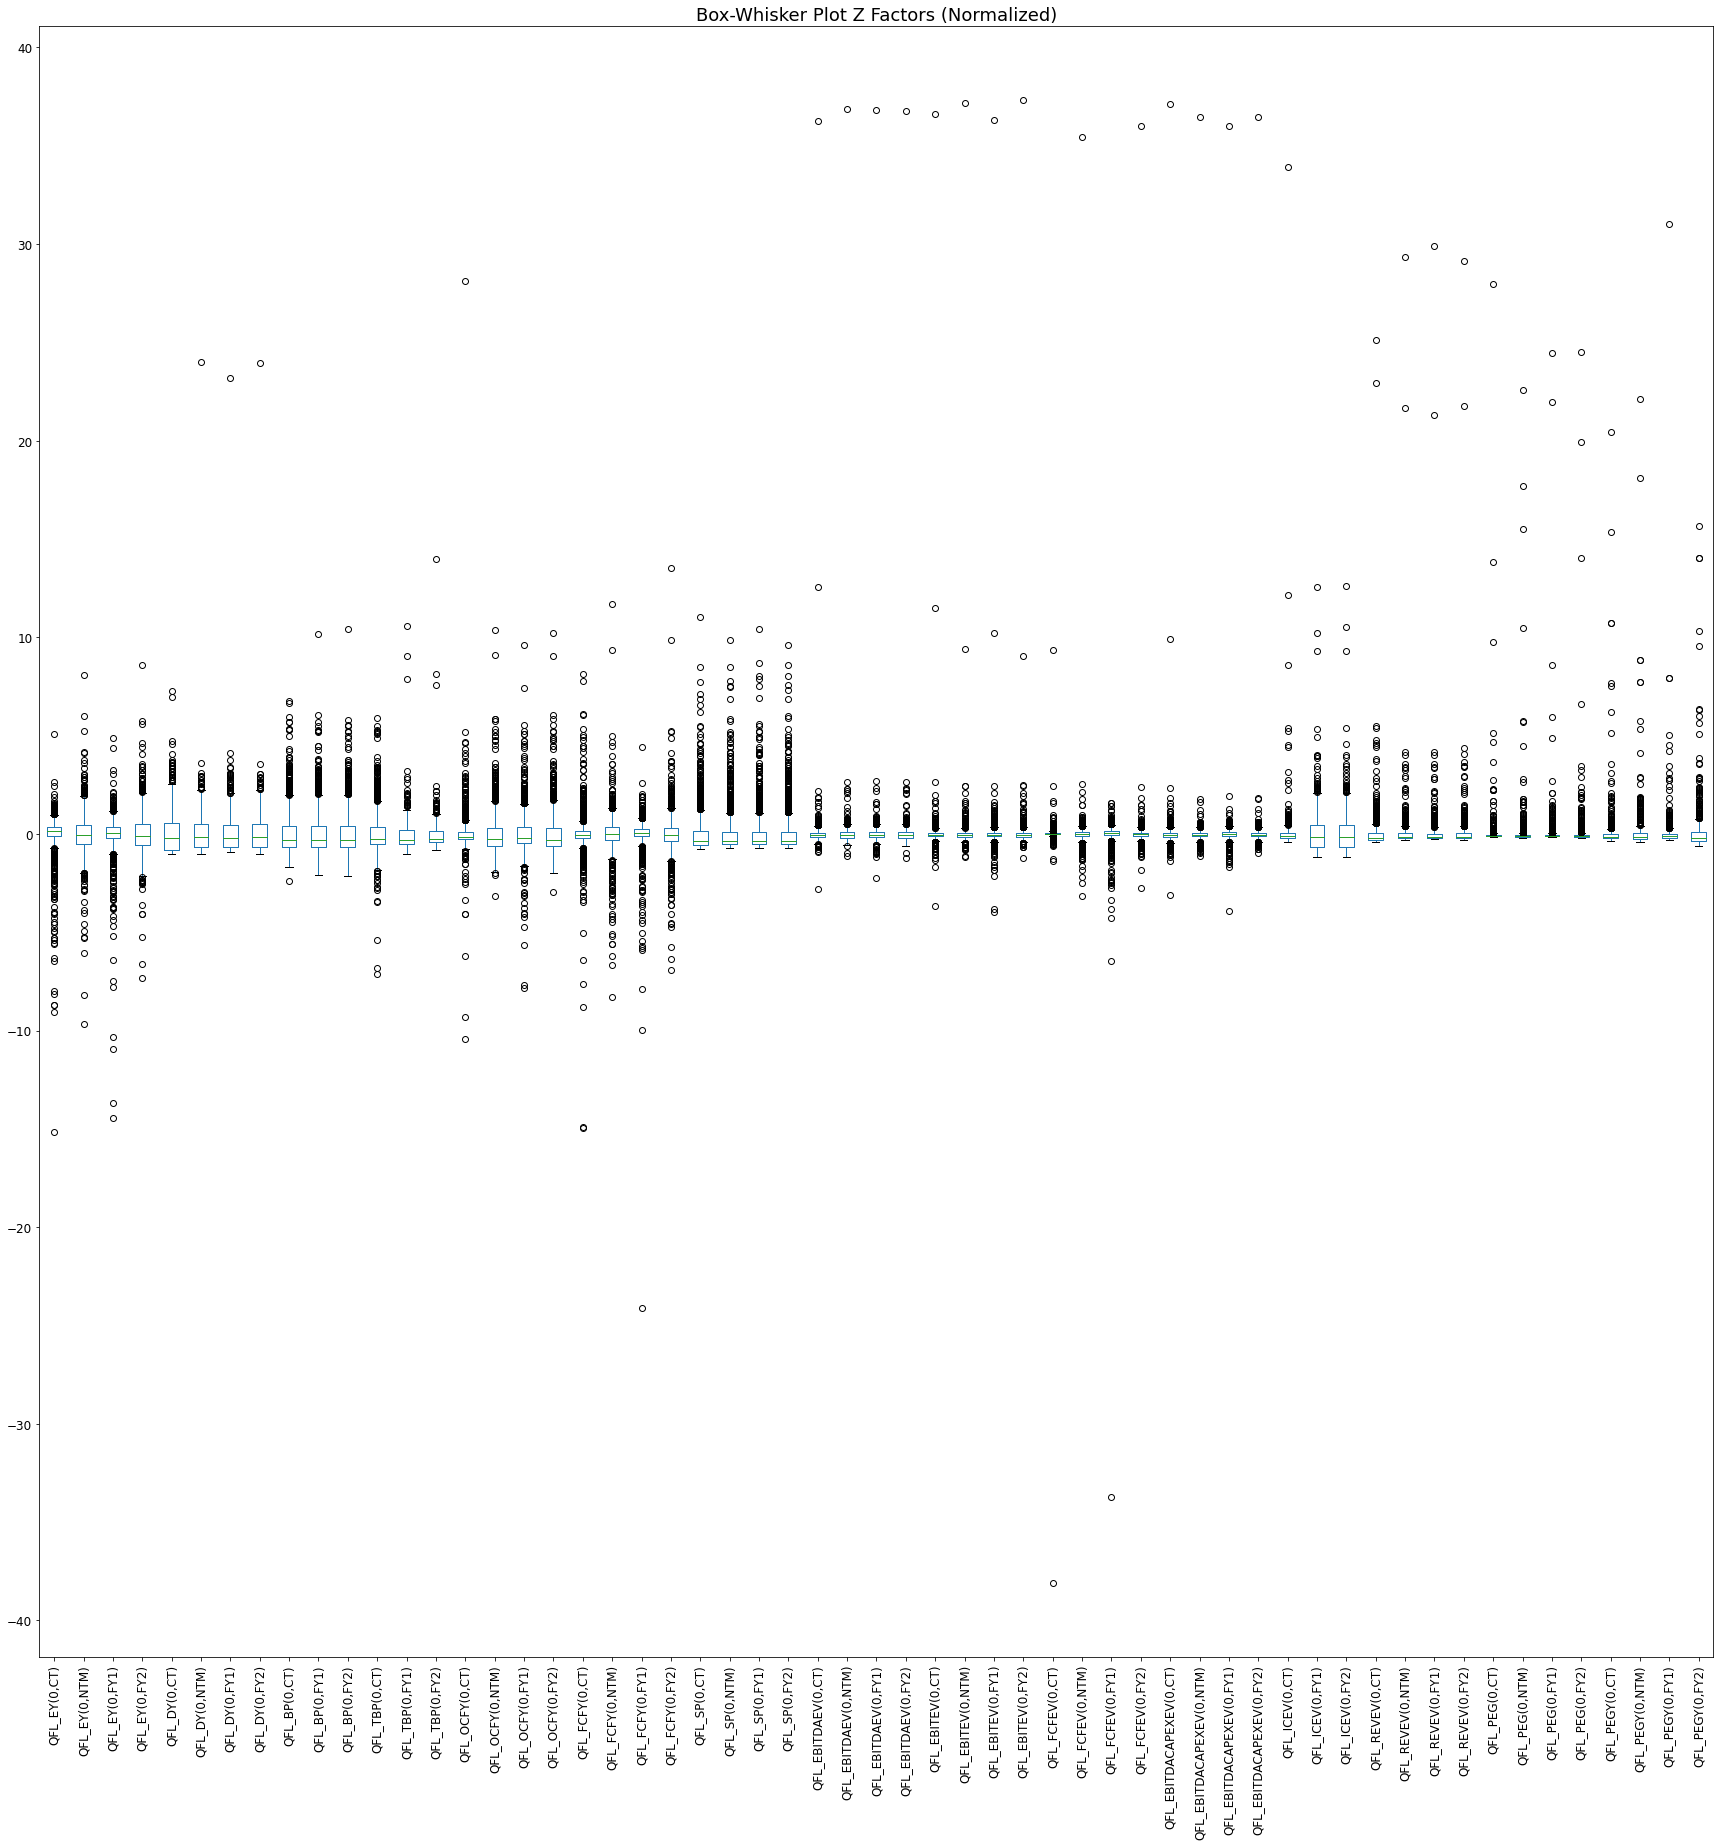

In [21]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [22]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)",MFR
0,-15.184700,-9.676876,-14.427191,-7.333445,-1.027801,-1.009824,-0.939975,-1.023738,-2.409992,-2.075298,-2.126783,-7.144477,-1.014802,-0.834322,-10.410981,-3.169478,-7.858441,-2.965165,-14.948795,-8.307045,-24.119423,-6.916638,-0.775755,-0.710683,-0.697865,-0.710195,-2.788555,-1.135056,-2.258322,-1.238805,-3.674878,-1.181966,-3.947817,-1.212803,-38.091106,-3.160348,-33.717010,-2.770877,-3.096604,-1.147543,-3.922736,-0.973553,-0.390812,-1.161814,-1.177933,-0.422531,-0.297812,-0.283939,-0.301838,-0.153242,-0.185234,-0.171432,-0.191104,-0.342460,-0.426303,-0.313637,-0.623708,-4.536517
1,-9.075469,-8.189819,-13.707962,-6.633653,-1.027801,-1.009824,-0.939975,-1.023738,-1.677529,-1.787325,-1.911331,-6.839334,-0.977328,-0.795340,-9.336723,-2.072037,-7.704713,-1.987024,-14.918951,-6.680893,-9.978845,-6.355602,-0.724502,-0.710683,-0.697865,-0.710195,-0.937613,-0.963159,-1.154490,-0.983435,-1.670638,-1.137202,-3.802569,-0.690867,-1.362868,-2.498215,-6.473358,-1.854053,-1.362708,-0.950304,-1.709843,-0.766869,-0.337139,-1.150934,-1.167429,-0.386727,-0.297812,-0.283939,-0.301838,-0.152765,-0.182925,-0.169701,-0.188388,-0.340873,-0.417755,-0.309224,-0.609633,-2.668241
2,-8.720347,-6.050566,-10.934936,-5.252794,-1.027801,-1.009824,-0.939975,-1.023738,-1.577632,-1.605827,-1.591085,-5.385077,-0.926287,-0.750391,-6.219098,-1.979767,-5.643340,-1.538698,-8.808421,-6.208629,-7.913616,-5.736695,-0.723957,-0.705184,-0.697478,-0.704716,-0.859409,-0.606362,-1.010455,-0.607462,-1.350417,-0.804934,-2.117041,-0.661217,-1.296207,-2.213929,-4.289018,-1.183690,-1.158677,-0.905691,-1.522554,-0.761909,-0.336774,-1.150831,-1.163928,-0.386355,-0.294796,-0.283756,-0.298788,-0.151293,-0.181902,-0.169117,-0.187470,-0.335633,-0.410694,-0.305981,-0.597747,-2.127718
3,-8.716129,-5.311404,-10.311320,-4.097549,-1.027801,-1.009824,-0.939975,-1.023738,-1.470242,-1.423352,-1.394266,-3.461753,-0.880077,-0.688900,-4.064690,-1.946990,-4.731646,-1.526832,-7.640891,-5.609140,-5.885551,-4.742630,-0.723957,-0.702899,-0.693446,-0.702200,-0.758799,-0.582640,-0.965075,-0.595482,-1.246803,-0.778597,-1.853534,-0.654471,-0.627342,-1.832104,-3.795144,-1.105968,-1.068908,-0.881147,-1.451712,-0.747511,-0.333464,-1.148137,-1.163429,-0.386355,-0.293127,-0.281360,-0.296954,-0.149915,-0.181858,-0.165967,-0.186975,-0.326856,-0.409037,-0.295682,-0.596721,-1.857689
4,-8.162442,-5.259025,-7.793513,-4.054879,-1.027801,-1.009824,-0.939975,-1.023738,-1.385778,-1.380282,-1.387678,-3.400643,-0.866233,-0.679613,-4.055517,-1.503651,-4.202145,-1.432165,-6.402643,-5.576457,-5.827136,-4.583040,-0.721656,-0.701689,-0.692819,-0.700502,-0.653229,-0.554627,-0.957781,-0.559680,-1.097612,-0.774862,-1.846241,-0.580691,-0.577973,-1.611551,-3.381948,-1.039239,-1.067616,-0.785714,-1.391297,-0.659391,-0.331666,-1.147057,-1.162860,-0.384700,-0.293109,-0.281342,-0.296694,-0.148937,-0.179476,-0.165655,-0.185769,-0.322559,-0.397810,-0.293529,-0.588049,-1.727886


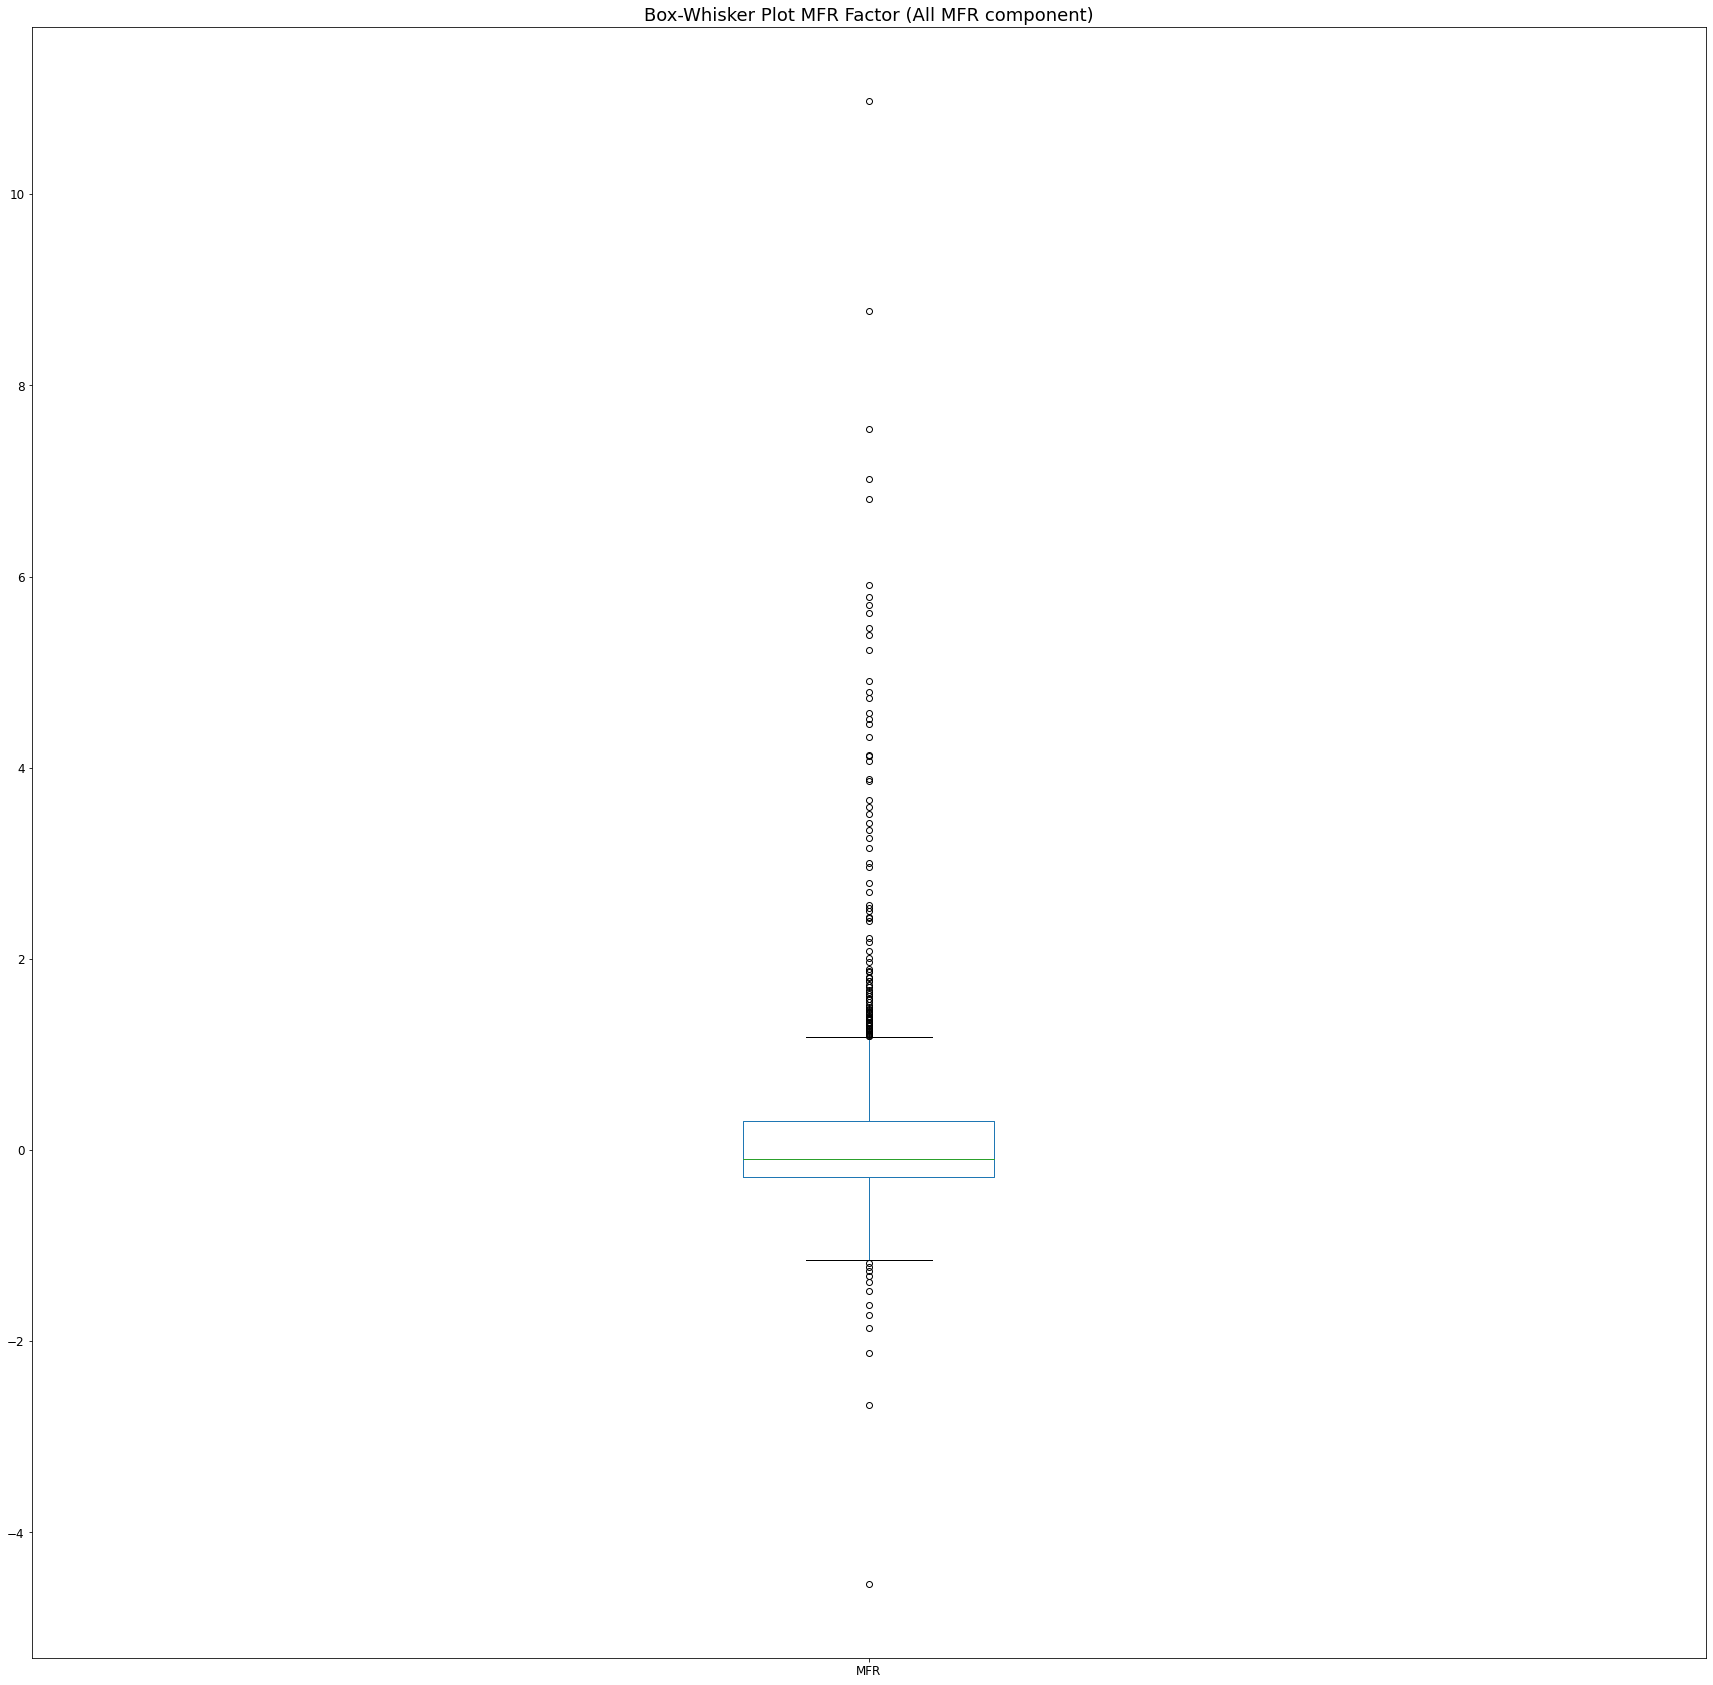

In [23]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

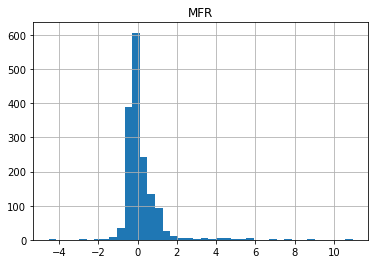

In [24]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [75]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.03


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


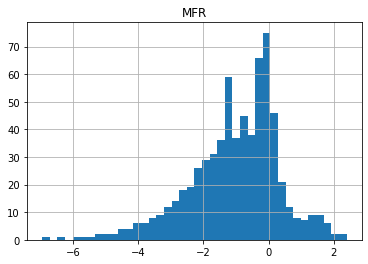

In [25]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [26]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)"
0,2.896269,3.400158,3.368390,3.558475,0.688786,0.735155,0.725872,0.781422,0.032962,0.027515,0.026216,NaN,0.024528,0.023562,4.069840,4.364474,4.310444,4.633740,3.701116,3.840130,3.782173,4.128966,0.138303,-1.827836,-1.836426,-1.786103,3.794066,4.620283,4.586364,4.789324,3.244983,3.979834,3.935598,4.200287,3.643585,3.780438,3.723382,4.064784,3.431073,4.064911,4.032780,4.225039,0.085614,-2.489795,-2.505326,0.136153,-1.843503,-1.852089,-1.801767,1.472256,1.311858,1.321245,1.266348,1.388872,1.223102,1.233562,1.172261
1,2.918797,3.291511,3.165014,3.466788,1.046387,1.043441,1.015244,1.082512,0.075829,0.085226,0.101680,0.044602,0.074835,0.095997,4.067733,4.465352,4.265662,4.742045,3.025296,3.102482,2.972066,3.283189,0.090407,-2.298972,-2.338731,-2.246384,4.363731,4.939514,4.711505,5.255448,3.570719,4.055735,3.877933,4.302102,3.130651,3.210524,3.075567,3.397524,3.284993,3.665087,3.489891,3.907844,0.125770,-2.050978,-1.926645,0.093555,-2.264740,-2.304497,-2.212150,0.469360,0.349185,0.388375,0.297304,0.421680,0.301636,0.342081,0.248016
2,1.083850,1.429439,1.124772,1.457717,0.000000,0.000000,0.000000,0.000000,0.051629,0.056796,0.080059,0.042298,NaN,NaN,3.448711,4.246544,3.517875,4.314175,1.538298,2.531966,1.569221,2.621322,0.217023,-1.288478,-1.441274,-1.275412,2.710223,4.100751,3.281530,4.176786,1.250523,1.765561,1.263629,1.812147,1.512439,2.489403,1.542842,2.577258,0.831924,2.357581,1.475119,2.439487,0.100751,-2.571917,-2.313100,0.213375,-1.305430,-1.458229,-1.292367,0.574718,0.297955,0.537657,0.278366,0.574718,0.297955,0.537657,0.278366
3,3.194175,3.795488,3.393655,3.832784,0.000000,0.000000,0.000000,0.000000,0.148785,0.158608,0.201627,0.123794,0.133011,0.164278,4.638536,5.902747,4.884094,5.997293,2.793181,3.327332,2.903743,3.366647,0.099807,-2.041445,-2.242196,-2.024711,4.717606,6.591865,5.830592,6.662521,3.851397,4.772218,4.077750,4.836675,2.960408,3.526539,3.077589,3.568208,2.761771,3.860249,3.712755,3.873939,0.171262,-1.783172,-1.543187,0.105783,-1.983303,-2.184056,-1.966563,0.178509,0.006025,0.117931,-0.003754,0.178509,0.006025,0.117931,-0.003754
4,2.949484,3.437809,2.921742,3.485707,0.000000,0.000000,0.000000,0.000000,0.175847,0.184196,0.216998,0.157356,NaN,NaN,4.697139,5.952622,4.925555,6.047948,2.809661,3.908502,3.154020,3.978528,0.141586,-1.936866,-2.113801,-1.921925,4.336804,6.903169,5.753911,7.009837,3.126334,4.121856,3.335778,4.194815,3.076594,4.279831,3.453669,4.356510,2.270006,4.499186,3.696101,4.573724,0.215060,-1.583137,-1.421934,0.155037,-1.846104,-2.023046,-1.831164,0.739851,0.586647,0.749302,0.572811,0.739851,0.586647,0.749302,0.572811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,2.846347,8.207607,2.617923,8.726411,7.679701,7.693219,7.691573,7.693373,1.021488,1.264704,1.271106,1.010481,NaN,NaN,7.850093,NaN

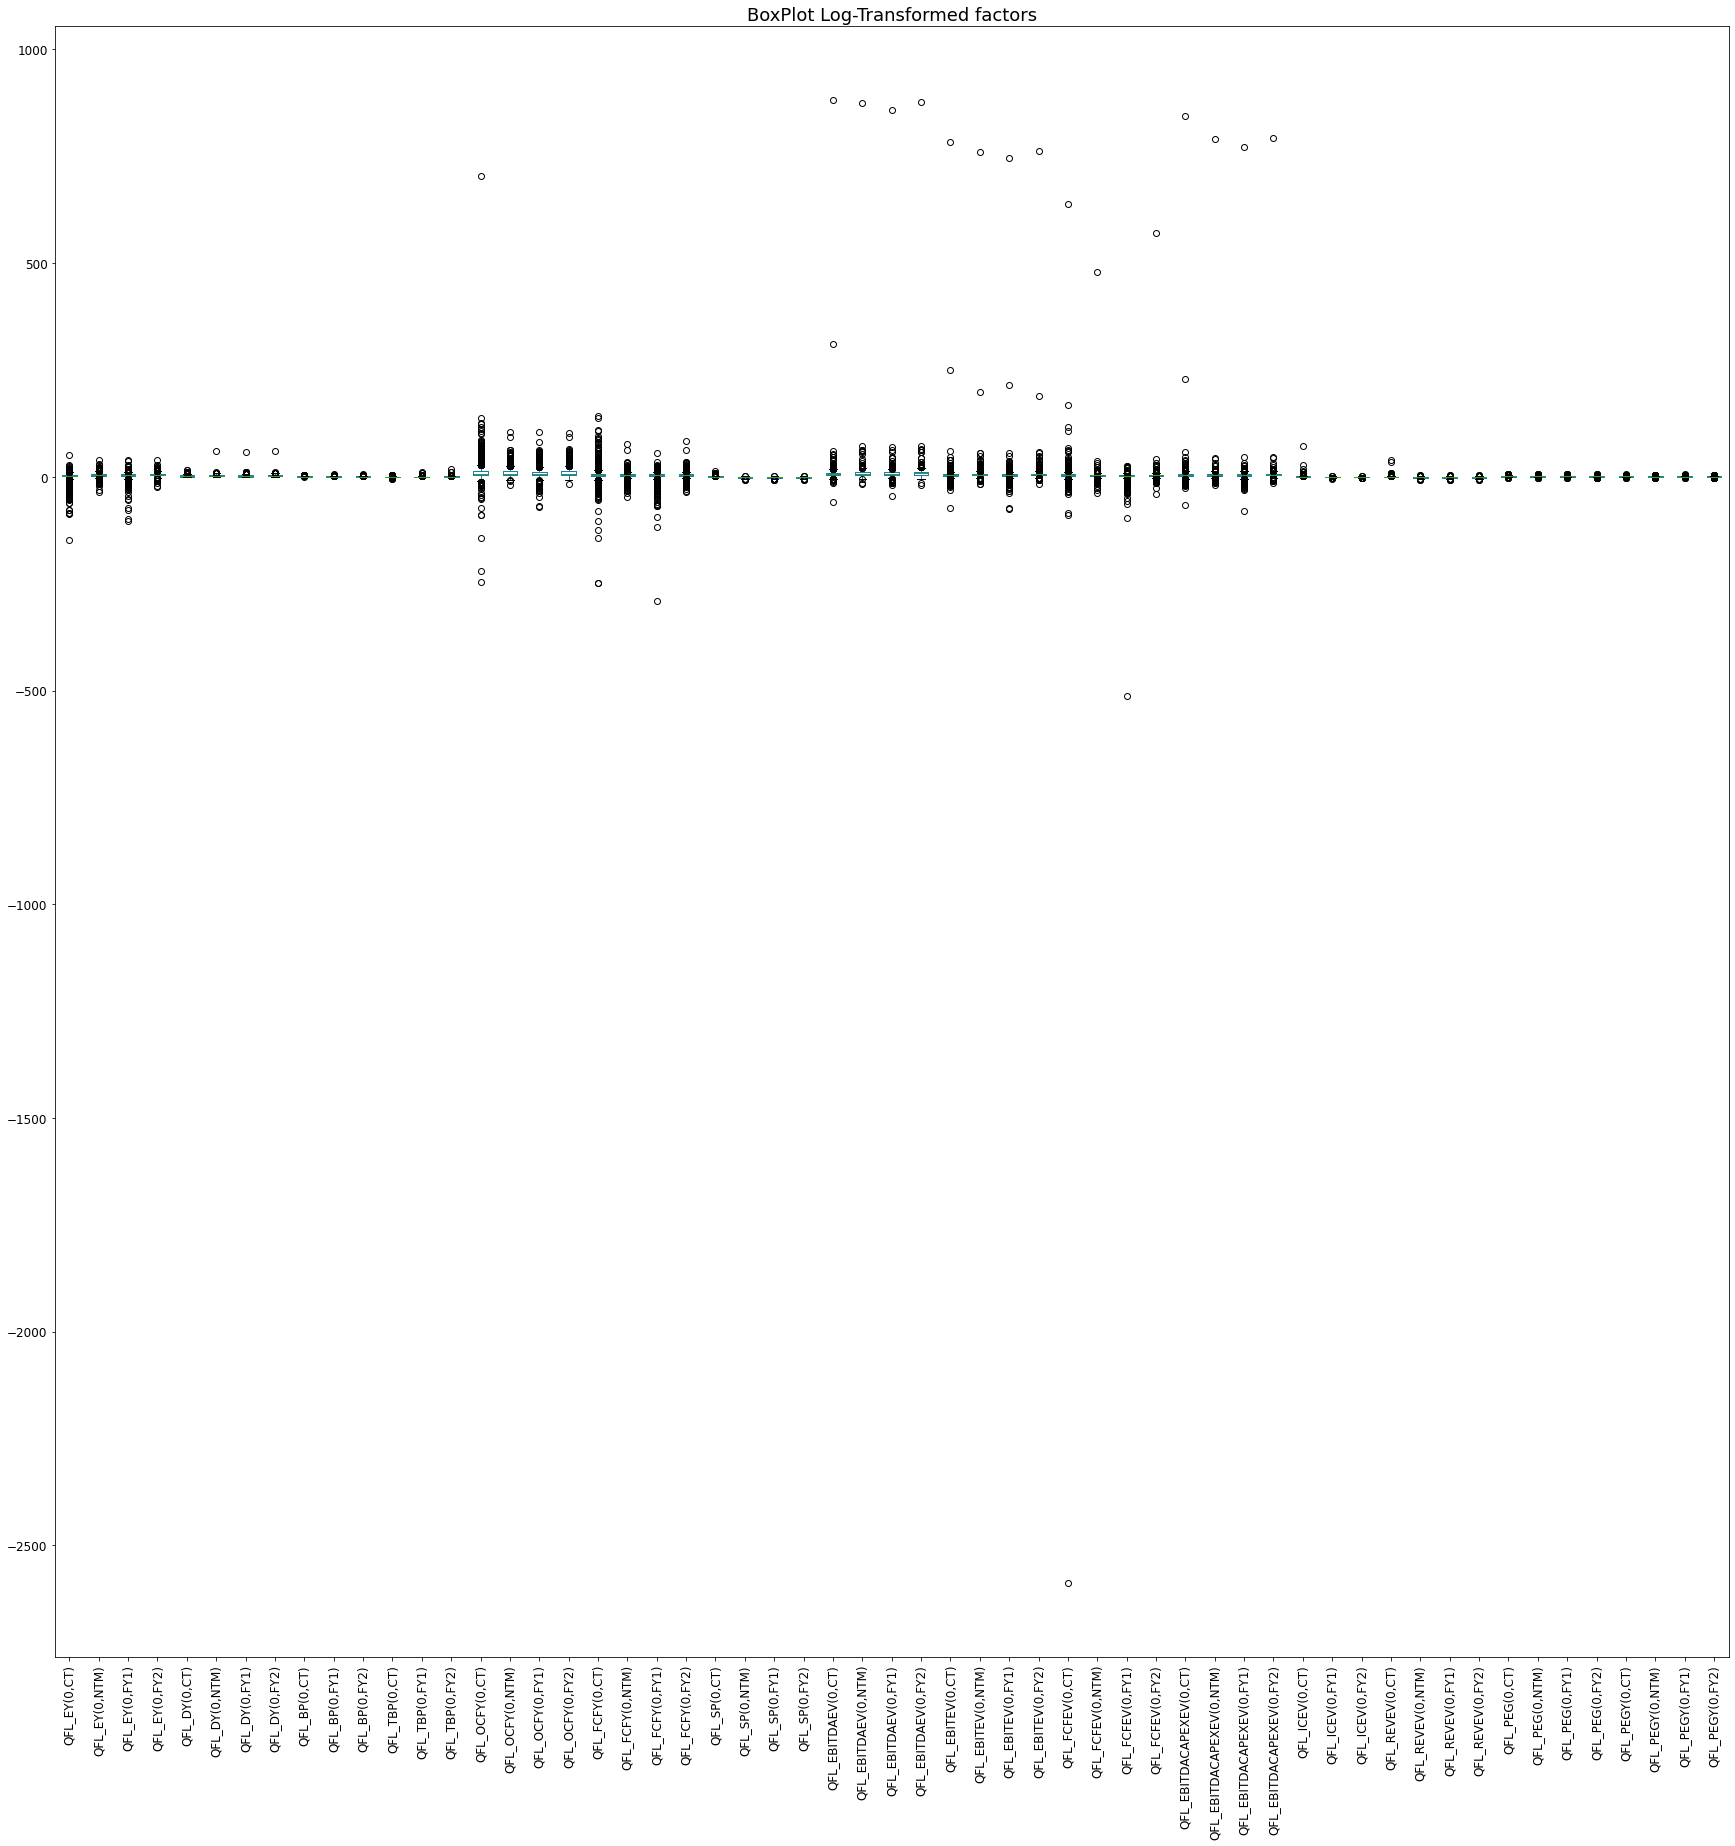

In [44]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [28]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)",MFR
0,0.104716,-0.409838,-0.007963,-0.494957,-0.690975,-0.709327,-0.639033,-0.706122,-0.905499,-0.935821,-0.960507,NaN,-0.500417,-0.433546,-0.255186,-0.595252,-0.402990,-0.591477,-0.097985,-0.069573,0.085118,-0.077410,-0.594801,-0.822431,-0.732696,-0.802970,-0.175095,-0.201663,-0.153329,-0.206359,-0.076230,-0.124290,-0.065516,-0.126915,0.011479,0.006807,0.109073,0.007060,-0.075207,-0.082790,-0.032887,-0.088020,-0.301394,-2.008623,-2.129509,-0.296874,-0.615932,-0.530944,-0.594438,0.227593,0.438369,0.261208,0.443710,0.515442,0.825282,0.583546,0.831541,-0.283426
1,0.106999,-0.435234,-0.035273,-0.518128,-0.516104,-0.583314,-0.519061,-0.583742,-0.831410,-0.840589,-0.838043,-0.428231,-0.450375,-0.377633,-0.255271,-0.584105,-0.407474,-0.579636,-0.137851,-0.188730,0.018242,-0.220738,-0.639718,-1.225642,-1.147229,-1.198266,-0.151433,-0.188084,-0.147902,-0.186603,-0.060941,-0.120545,-0.068344,-0.121882,0.003938,-0.035694,0.066705,-0.035286,-0.081672,-0.101370,-0.058354,-0.102738,-0.282529,-1.498406,-1.437890,-0.324986,-0.992394,-0.921691,-0.962178,-0.796528,-0.539539,-0.739346,-0.545040,-0.612359,-0.301018,-0.530715,-0.306335,-0.449083
2,-0.078965,-0.870487,-0.309241,-1.025869,-1.027801,-1.009824,-0.939975,-1.023738,-0.873236,-0.887503,-0.873130,-0.431864,NaN,NaN,-0.280352,-0.608283,-0.482356,-0.626416,-0.225568,-0.280889,-0.097565,-0.332900,-0.520977,-0.360832,-0.406591,-0.364380,-0.220115,-0.223763,-0.209915,-0.232320,-0.169841,-0.233547,-0.196576,-0.244961,-0.019850,-0.089470,-0.033538,-0.087341,-0.190239,-0.162129,-0.152868,-0.170873,-0.294283,-2.104107,-1.899768,-0.245912,-0.135054,-0.190764,-0.137970,-0.688941,-0.591580,-0.579233,-0.564363,-0.433908,-0.305518,-0.286264,-0.268970,-0.460049
3,0.134908,-0.317431,-0.004570,-0.425632,-1.027801,-1.009824,-0.939975,-1.023738,-0.705317,-0.719498,-0.675847,-0.303367,-0.392506,-0.324926,-0.232145,-0.425276,-0.345546,-0.442398,-0.151543,-0.152408,0.012602,-0.206595,-0.630903,-1.005243,-1.067563,-1.007890,-0.136733,-0.117795,-0.099370,-0.126966,-0.047767,-0.085193,-0.058543,-0.095458,0.001436,-0.012127,0.066837,-0.024454,-0.104828,-0.092301,-0.047899,-0.104311,-0.261156,-1.187025,-0.979593,-0.316916,-0.740872,-0.817665,-0.742110,-1.093534,-0.888130,-1.029412,-0.852220,-0.895909,-0.662341,-0.810880,-0.616300,-0.462631
4,0.110109,-0.401037,-0.067940,-0.513347,-1.027801,-1.009824,-0.939975,-1.023738,-0.658544,-0.677274,-0.650903,-0.250448,NaN,NaN,-0.229770,-0.419765,-0.341394,-0.436859,-0.150571,-0.058528,0.033263,-0.102904,-0.591722,-0.915742,-0.961603,-0.919616,-0.152551,-0.104552,-0.102696,-0.112245,-0.081798,-0.117283,-0.094937,-0.127185,0.003144,0.044048,0.091433,0.025573,-0.126593,-0.062610,-0.048680,-0.071840,-0.240580,-0.954441,-0.834676,-0.284412,-0.618256,-0.678600,-0.620780,-0.520312,-0.298319,-0.352232,-0.263931,-0.241353,0.047348,-0.021730,0.093533,-0.346063


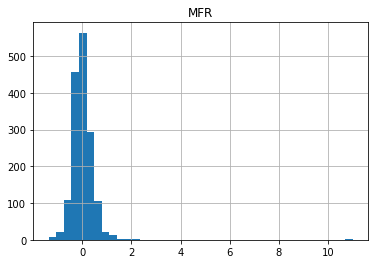

In [29]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [74]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: 0.06
Information Coefficient (P-Value): 0.01


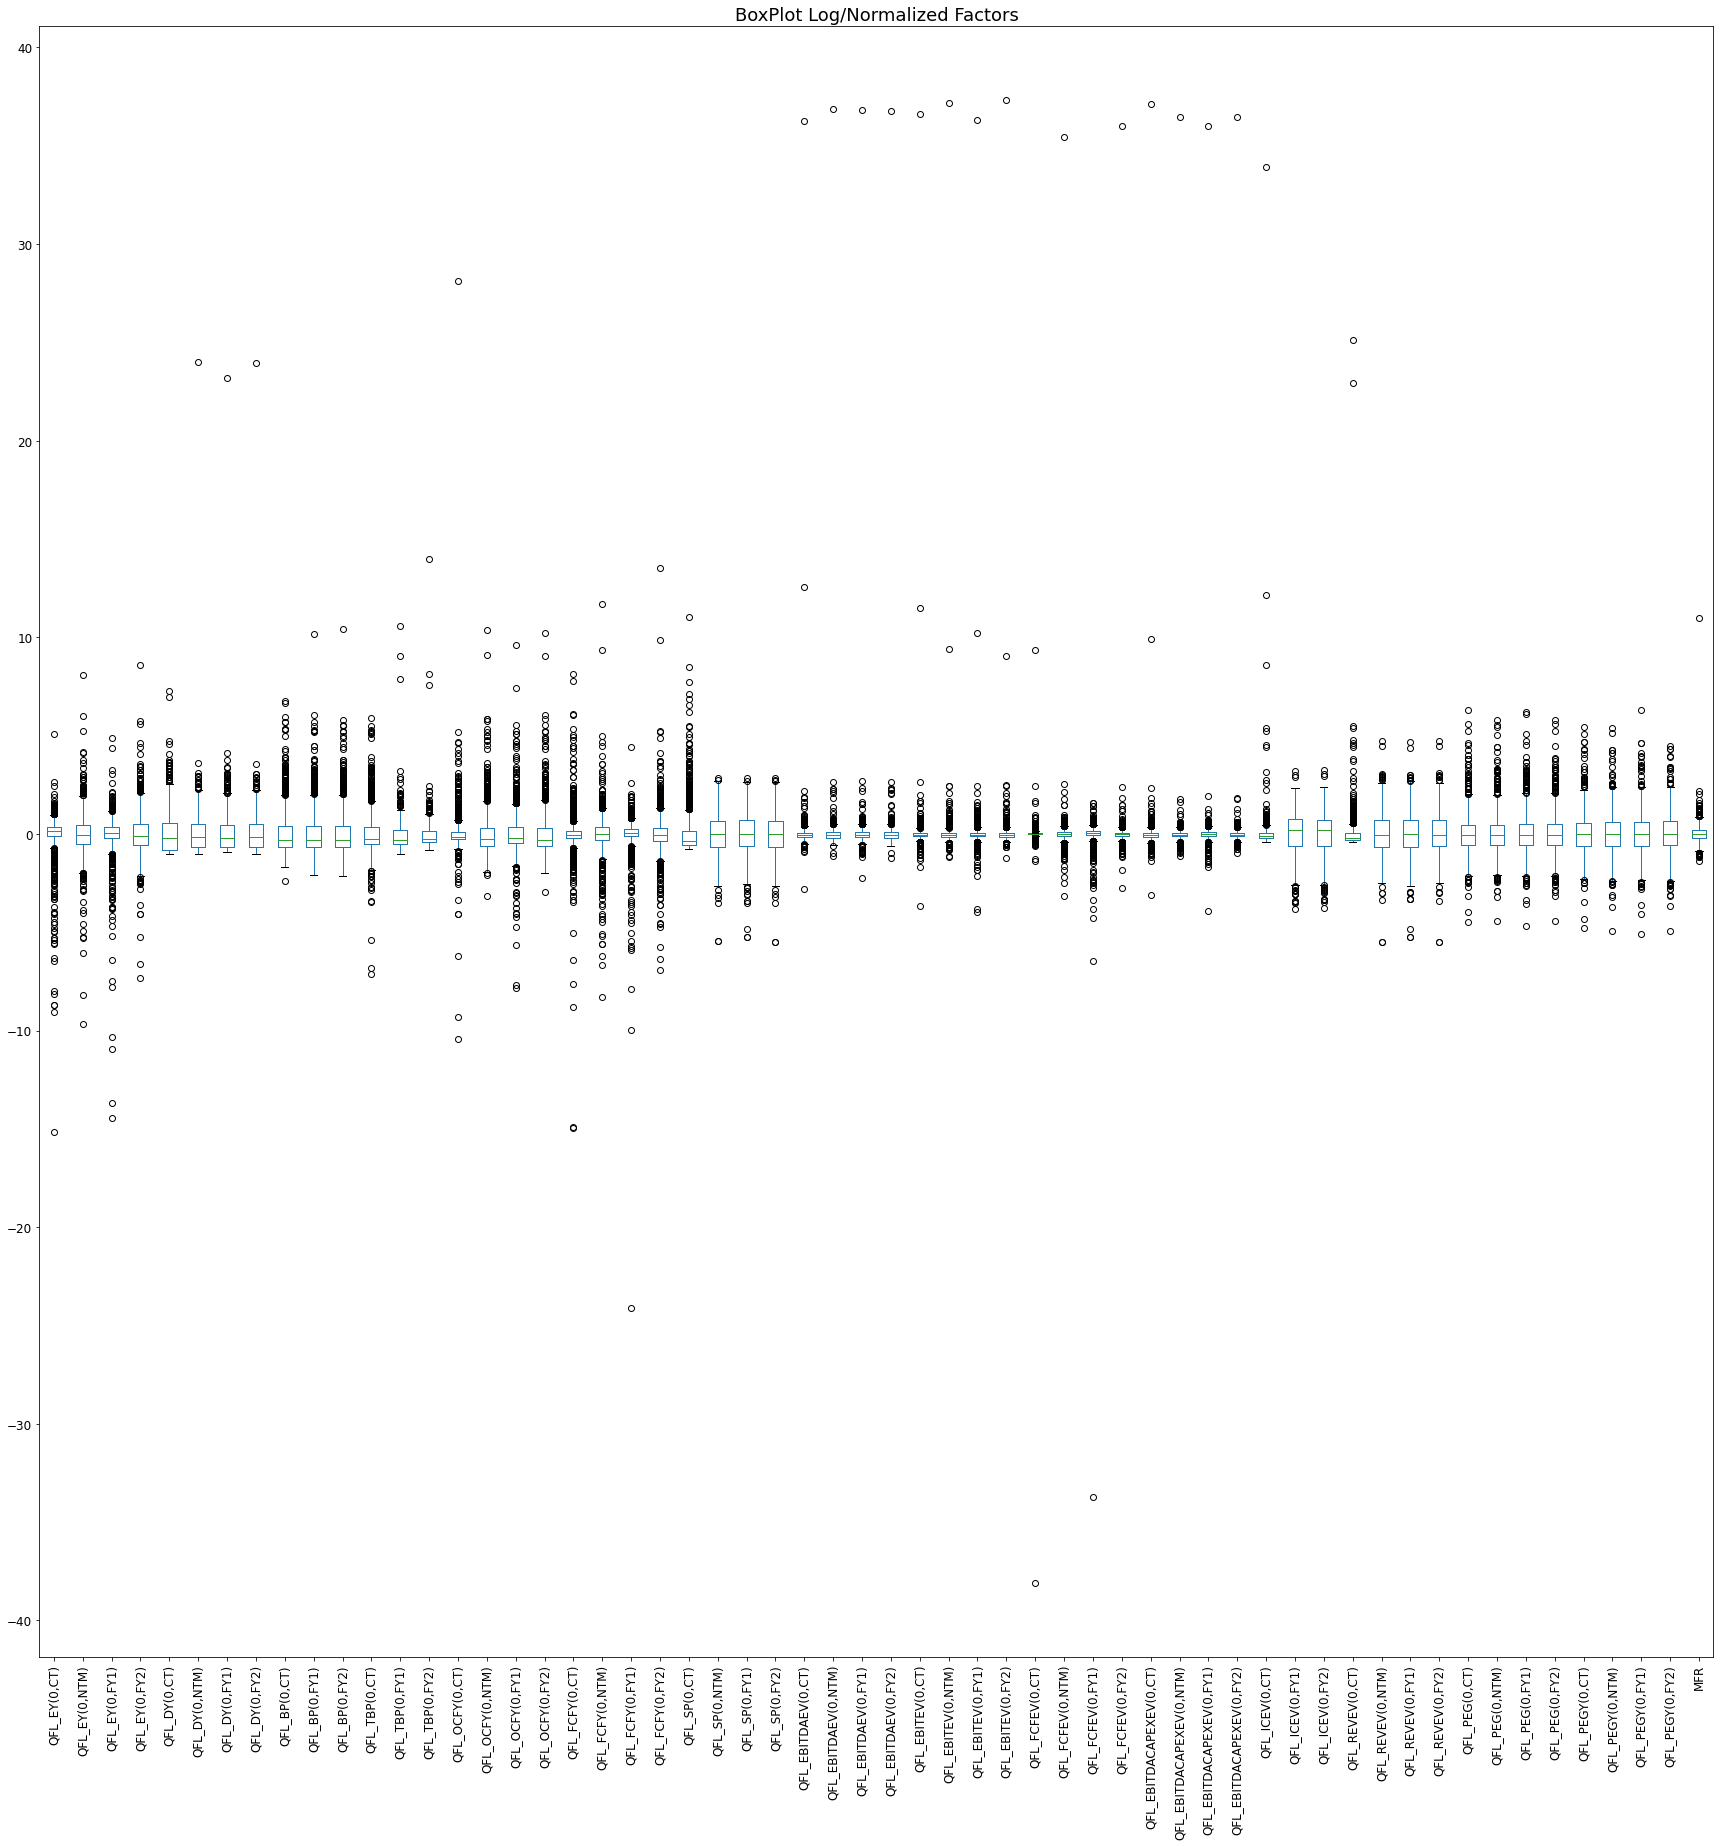

In [30]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [31]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_EY(0,CT)","QFL_EY(0,NTM)","QFL_EY(0,FY1)","QFL_EY(0,FY2)","QFL_DY(0,CT)","QFL_DY(0,NTM)","QFL_DY(0,FY1)","QFL_DY(0,FY2)","QFL_BP(0,CT)","QFL_BP(0,FY1)","QFL_BP(0,FY2)","QFL_TBP(0,CT)","QFL_TBP(0,FY1)","QFL_TBP(0,FY2)","QFL_OCFY(0,CT)","QFL_OCFY(0,NTM)","QFL_OCFY(0,FY1)","QFL_OCFY(0,FY2)","QFL_FCFY(0,CT)","QFL_FCFY(0,NTM)","QFL_FCFY(0,FY1)","QFL_FCFY(0,FY2)","QFL_SP(0,CT)","QFL_SP(0,NTM)","QFL_SP(0,FY1)","QFL_SP(0,FY2)","QFL_EBITDAEV(0,CT)","QFL_EBITDAEV(0,NTM)","QFL_EBITDAEV(0,FY1)","QFL_EBITDAEV(0,FY2)","QFL_EBITEV(0,CT)","QFL_EBITEV(0,NTM)","QFL_EBITEV(0,FY1)","QFL_EBITEV(0,FY2)","QFL_FCFEV(0,CT)","QFL_FCFEV(0,NTM)","QFL_FCFEV(0,FY1)","QFL_FCFEV(0,FY2)","QFL_EBITDACAPEXEV(0,CT)","QFL_EBITDACAPEXEV(0,NTM)","QFL_EBITDACAPEXEV(0,FY1)","QFL_EBITDACAPEXEV(0,FY2)","QFL_ICEV(0,CT)","QFL_ICEV(0,FY1)","QFL_ICEV(0,FY2)","QFL_REVEV(0,CT)","QFL_REVEV(0,NTM)","QFL_REVEV(0,FY1)","QFL_REVEV(0,FY2)","QFL_PEG(0,CT)","QFL_PEG(0,NTM)","QFL_PEG(0,FY1)","QFL_PEG(0,FY2)","QFL_PEGY(0,CT)","QFL_PEGY(0,NTM)","QFL_PEGY(0,FY1)","QFL_PEGY(0,FY2)",ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,2.896269,3.400158,3.368390,3.558475,0.688786,0.735155,0.725872,0.781422,0.032962,0.027515,0.026216,NaN,0.024528,0.023562,4.069840,4.364474,4.310444,4.633740,3.701116,3.840130,3.782173,4.128966,0.138303,0.160761,0.159386,0.167612,3.794066,4.620283,4.586364,4.789324,3.244983,3.979834,3.935598,4.200287,3.643585,3.780438,3.723382,4.064784,3.431073,4.064911,4.032780,4.225039,0.085614,0.082927,0.081649,0.136153,0.158262,0.156909,0.165007,4.359060,3.713066,3.748085,3.547871,4.010325,3.397712,3.433439,3.229286,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,2.918797,3.291511,3.165014,3.466788,1.046387,1.043441,1.015244,1.082512,0.075829,0.085226,0.101680,0.044602,0.074835,0.095997,4.067733,4.465352,4.265662,4.742045,3.025296,3.102482,2.972066,3.283189,0.090407,0.100362,0.096450,0.105781,4.363731,4.939514,4.711505,5.255448,3.570719,4.055735,3.877933,4.302102,3.130651,3.210524,3.075567,3.397524,3.284993,3.665087,3.489891,3.907844,0.125770,0.128609,0.145636,0.093555,0.103857,0.099809,0.109465,1.598971,1.417912,1.474582,1.346224,1.524520,1.352069,1.407874,1.281481,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,1.083850,1.429439,1.124772,1.457717,0.000000,0.000000,0.000000,0.000000,0.051629,0.056796,0.080059,0.042298,NaN,NaN,3.448711,4.246544,3.517875,4.314175,1.538298,2.531966,1.569221,2.621322,0.217023,0.275690,0.236626,0.279316,2.710223,4.100751,3.281530,4.176786,1.250523,1.765561,1.263629,1.812147,1.512439,2.489403,1.542842,2.577258,0.831924,2.357581,1.475119,2.439487,0.100751,0.076389,0.098954,0.213375,0.271056,0.232648,0.274620,1.776629,1.347101,1.711991,1.320970,1.776629,1.347101,1.711991,1.320970,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,3.194175,3.795488,3.393655,3.832784,0.000000,0.000000,0.000000,0.000000,0.148785,0.158608,0.201627,0.123794,0.133011,0.164278,4.638536,5.902747,4.884094,5.997293,2.793181,3.327332,2.903743,3.366647,0.099807,0.129841,0.106225,0.132032,4.717606,6.591865,5.830592,6.662521,3.851397,4.772218,4.077750,4.836675,2.960408,3.526539,3.077589,3.568208,2.761771,3.860249,3.712755,3.873939,0.171262,0.168104,0.213699,0.105783,0.137614,0.112584,0.139937,1.195434,1.006043,1.125166,0.996253,1.195434,1.006043,1.125166,0.996253,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,2.949484,3.437809,2.921742,3.485707,0.000000,0.000000,0.000000,0.000000,0.175847,0.184196,0.216998,0.157356,NaN,NaN,4.697139,5.952622,4.925555,6.047948,2.809661,3.

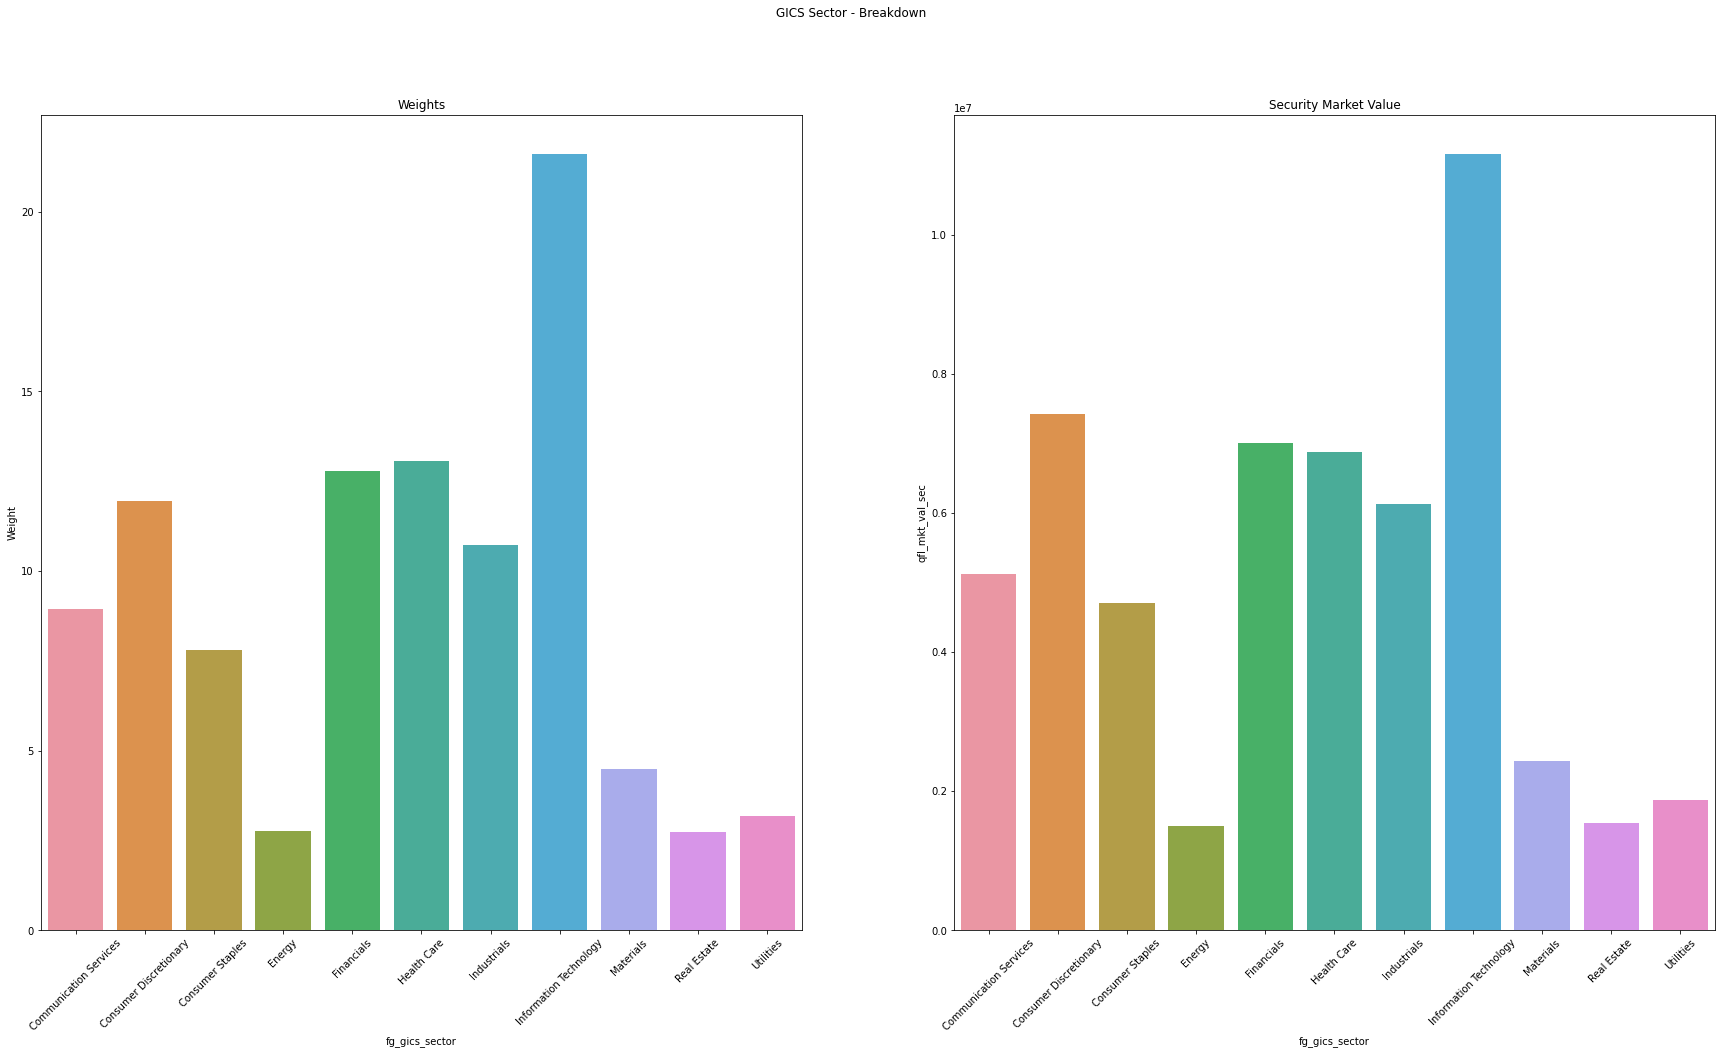

In [32]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

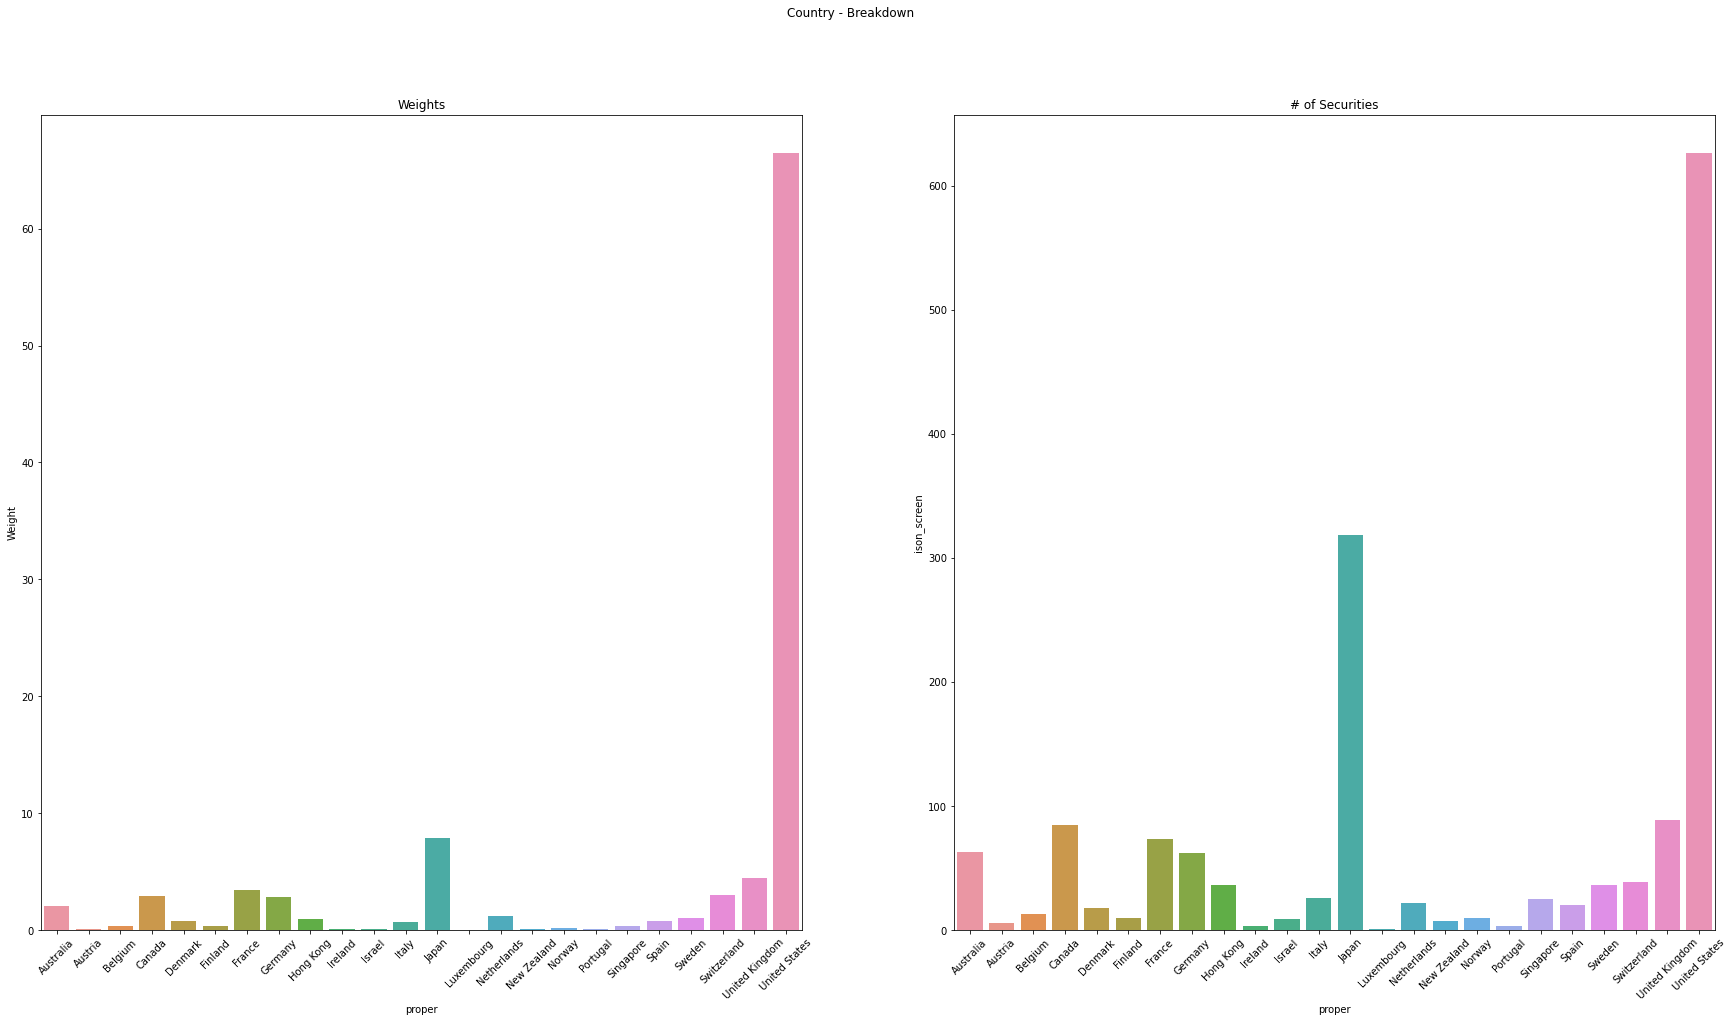

In [33]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

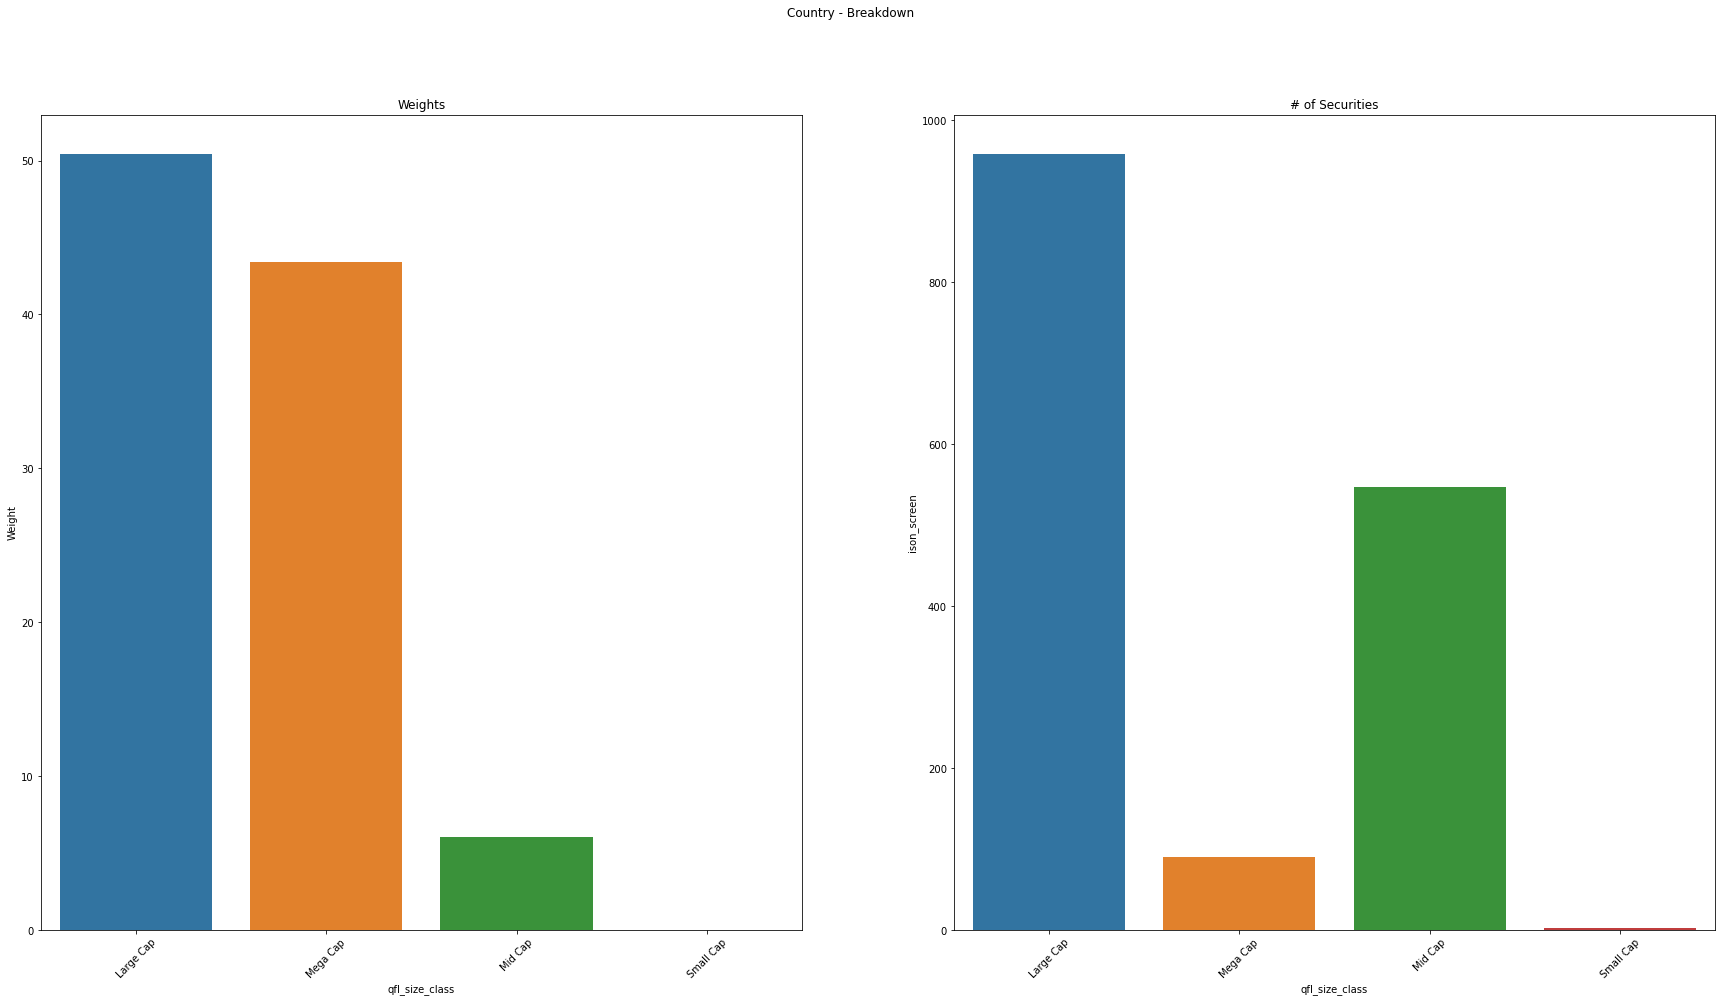

In [34]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [35]:
# Feature Selection

In [36]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [37]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-37-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [107]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [ True False False False False False False  True False False False False
 False False False False False False  True False False False False False
 False False False False False False]
Feature Ranking: [ 1 14 13  4 12 11 10  1 16 18 20 22  3 26 28 27 25  9  1  8  7  6  5  2
 15 17 19 21 23 24]


In [108]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_EY(0,CT)', 'QFL_DY(0,FY2)', 'QFL_EBITDAEV(0,CT)'], dtype='object')

In [109]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_EY(0,CT)","QFL_DY(0,FY2)","QFL_EBITDAEV(0,CT)"
"QFL_EY(0,CT)",1.000000,0.126923,0.090856
"QFL_DY(0,FY2)",0.126923,1.000000,0.086292
"QFL_EBITDAEV(0,CT)",0.090856,0.086292,1.000000


In [110]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_EY(0,CT)","QFL_DY(0,FY2)","QFL_EBITDAEV(0,CT)"
0,2.896269,0.781422,3.794066
1,2.918797,1.082512,4.363731
2,1.083850,0.000000,2.710223
3,3.194175,0.000000,4.717606
4,2.949484,0.000000,4.336804
...,...,...,...
1595,2.846347,7.693373,5.235334
1596,9.683292,4.761905,8.009394
1597,4.444969,5.523443,4.556962
1598,-78.677570,0.663265,-2.605879


In [111]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_EY(0,CT)","QFL_DY(0,FY2)","QFL_EBITDAEV(0,CT)",MFR
0,0.104848,-0.709682,-0.176592,-0.260476
1,0.107134,-0.586684,-0.152727,-0.210759
2,-0.079063,-1.028899,-0.221998,-0.443320
3,0.135077,-1.028899,-0.137903,-0.343908
4,0.110247,-1.028899,-0.153856,-0.357502


In [ ]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [112]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.13
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [113]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.13
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [114]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: 0.06
Information Coefficient (P-Value): 0.01


### Z-Score Only (All Components)

In [115]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.03
